## Predict items sold in the next 7 days for each store and item in the data set.

 ### Agenda
 1. Cleaning
 2. Exploratory Data Analysis
 3. Feature Engineering 
 4. Modeling
 5. Diagnosis & Forecasting
 6. Conclusion

In [1]:
## Libraries

# Configurations
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Data wrangling
import pandas as pd
import numpy as np
import re

# Modeling
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import shuffle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Other
import os
import time
import warnings
import random

warnings.filterwarnings("ignore")
seed = 20191110 # Please replace this with None, if you want to go really random :).

In [2]:
# Data
path = re.sub('notebooks','', os.getcwd())

df = pd.read_csv(path +'data/case_study_data_ver1.csv', sep = ';')
df.head()

,ITEM_ID,DATE_ID,STORE_ID,CAT_DAYOFWEEK,DUM_HOLIDAY,DUM_FREEWEEKDAY,DUM_WORKSATURDAY,DUM_HOLIDAY_SNGL,DUM_HOLIDAY_WHIT,DUM_HOLIDAY_XMAS,...,NUM_HOLIDAY_WHIT_TO,NUM_HOLIDAY_XMAS_FROM,NUM_HOLIDAY_XMAS_TO,NUM_SCHOOLBREAK_FROM_END,NUM_SCHOOLBREAK_TO_START,NUM_SCHOOLBREAK_FROM_START,NUM_SCHOOLBREAK_TO_END,QTY,PRICE,CUSTOMER
0,0.0,1.0,0.0,5,0,0,0,0,0,0,...,134.0,8.0,358.0,0.0,0.0,15.0,1.0,2.240.955,828.42,2155.0
1,0.0,1.0,1.0,5,0,0,0,0,0,0,...,134.0,8.0,358.0,0.0,0.0,15.0,1.0,897.845,828.47,1659.0
2,0.0,1.0,2.0,5,0,0,0,0,0,0,...,134.0,8.0,358.0,0.0,0.0,15.0,1.0,13.398.799.999.999.900,828.59,2036.0
3,0.0,1.0,3.0,5,0,0,0,0,0,0,...,134.0,8.0,358.0,0.0,0.0,15.0,1.0,899.555,828.33,1607.0
4,0.0,1.0,4.0,5,0,0,0,0,0,0,...,134.0,8.0,358.0,0.0,0.0,15.0,1.0,75.012,828.46,1966.0


## 1. Cleaning

- Removing NULLs, empty columns, weird errors in QTY
- Fixing odd formats in QTY
- 97.6% left

In [3]:
def check_nulls(df):
    print('{} rows'.format(len(df)))
    cols = list(df.keys())
    print('{} columns\n'.format(len(cols)))

    if df.isna().sum().sum() > 0:
        for col in range(len(cols)):
            if df[cols[col]].isna().sum() > 0:
                print('{} has {} NULL values'.format(cols[col],df[cols[col]].isna().sum()))
    else:
        print('No NULL values found')

In [4]:
check_nulls(df)

979971 rows
35 columns

ITEM_ID has 2 NULL values
DATE_ID has 2 NULL values
STORE_ID has 2 NULL values
NUM_HOLIDAY_WHIT_TO has 23239 NULL values
QTY has 2 NULL values
PRICE has 2 NULL values
CUSTOMER has 21 NULL values


The NULLs look huge. But this are roughly 20 rows per store-item-combination. With a real date, we could simply impute these missing values. Another way to deal with this issue would be to drop NUM_HOLIDAY_WHIT_TO completely since NUM_HOLIDAY_WHIT_FROM contains basically the same information. Here we'll drop the related rows.

In [5]:
before = len(df)
df = df.dropna() # getting rid of all NULLs

In [6]:
df['QTY'] = df['QTY'].astype(str)

patterns = []
proportion = []
n_rows = []
samples = []

for digit in range(4):

    pattern = '\.' + (digit+1) * '\d' + '$'
    outtakes = df[df.QTY.str.contains(pattern)]
    patterns.append(pattern)
    n_rows.append(len(outtakes))
    proportion.append(' {}%'.format(round(len(outtakes)/len(df)*100,2)))
    samples.append(outtakes.QTY.values[0])

patterns.append('[a-zA-Z]')
outtakes = df[df.QTY.str.contains('[a-zA-Z]')]
n_rows.append(len(outtakes))
proportion.append(' {}%'.format(round(len(outtakes)/len(df)*100,2)))
samples.append(outtakes.QTY.values[0])

df_digits = pd.DataFrame({'pattern':patterns,
                          'n_rows':n_rows,
                          'proportion':proportion,
                          'sample':samples}).sort_values('n_rows', ascending=False)

In [7]:
df_digits.head()

,pattern,n_rows,proportion,sample
0,\.\d$,872626,91.21%,9.0
2,\.\d\d\d$,83797,8.76%,2.240.955
4,[a-zA-Z],194,0.02%,21. Sep
1,\.\d\d$,50,0.01%,29.83
3,\.\d\d\d\d$,29,0.0%,0.9747


In [8]:
outtakes = df[df.QTY.str.contains('[a-zA-Z]|\.\d\d$|\.\d\d\d\d$')]
df = df.drop(outtakes.index)

df['QTY'] = df['QTY'].apply(lambda x: re.sub('\.','',re.sub('\..$','',x))).astype(float)

df = df.drop([key for key in list(df.keys()) if df[key].sum()==0], axis=1)

after = len(df)
round(after/before,5)

0.97599

## 2. Exploratory Data Analysis

We are dealing with a huge data set. There are different way to approach it. Here in we will look in particular at:
- Store-Item Combinations 
- Items based
- Store based

In [9]:
def tsplot(t,y, title, lags = None, figsize = (12,8)):
    """Fast Time Series Analysis: Trend, Distribution, Autocorrelation"""
    
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0))
    hist_ax = plt.subplot2grid(layout, (0,1))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    sns.lineplot(t,y,ax = ts_ax)
    ts_ax.set_title(title, fontsize = 14, fontweight = 'bold')
    y.plot(ax = hist_ax, kind = 'hist', bins = 25)
    hist_ax.set_title('Histogram')
    
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    
    [ax.set_xlim(0) for ax in [acf_ax,pacf_ax]]
    sns.despine()
    plt.tight_layout()
    
    return ts_ax, acf_ax, pacf_ax
    print()

### Store-Item Combinations over time

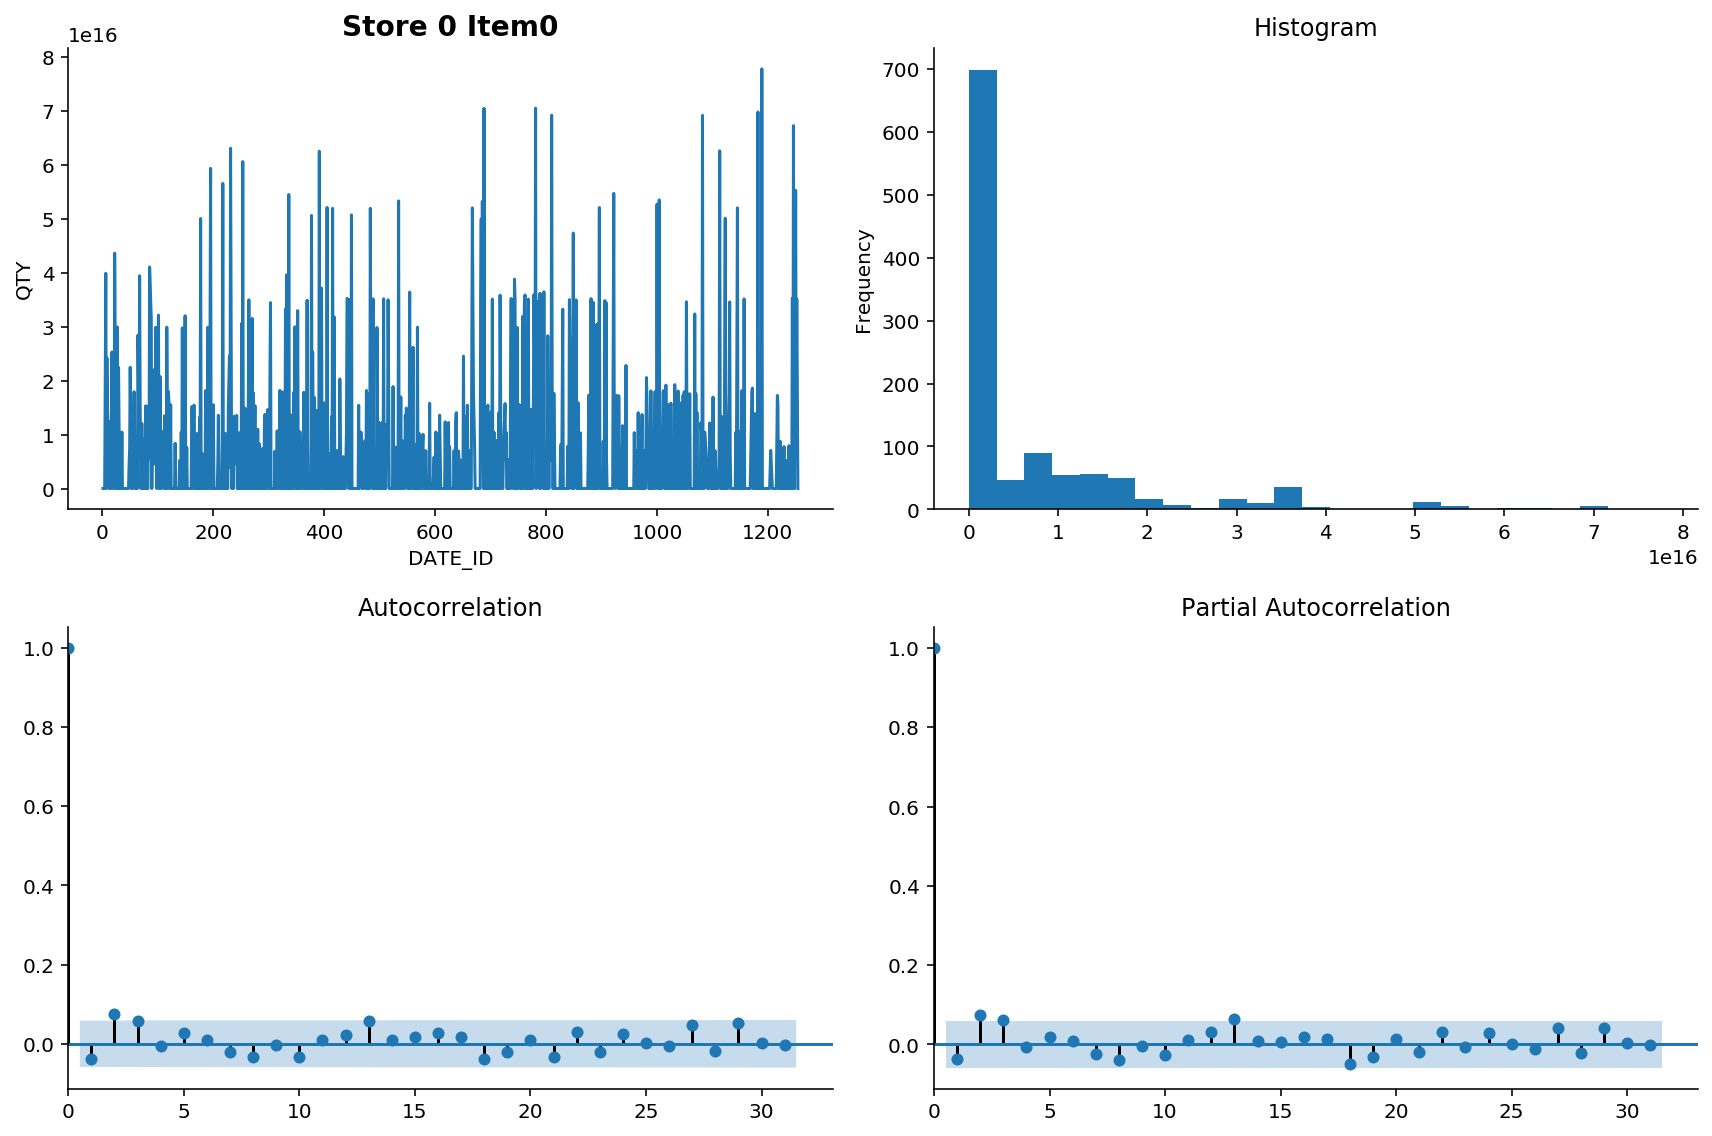

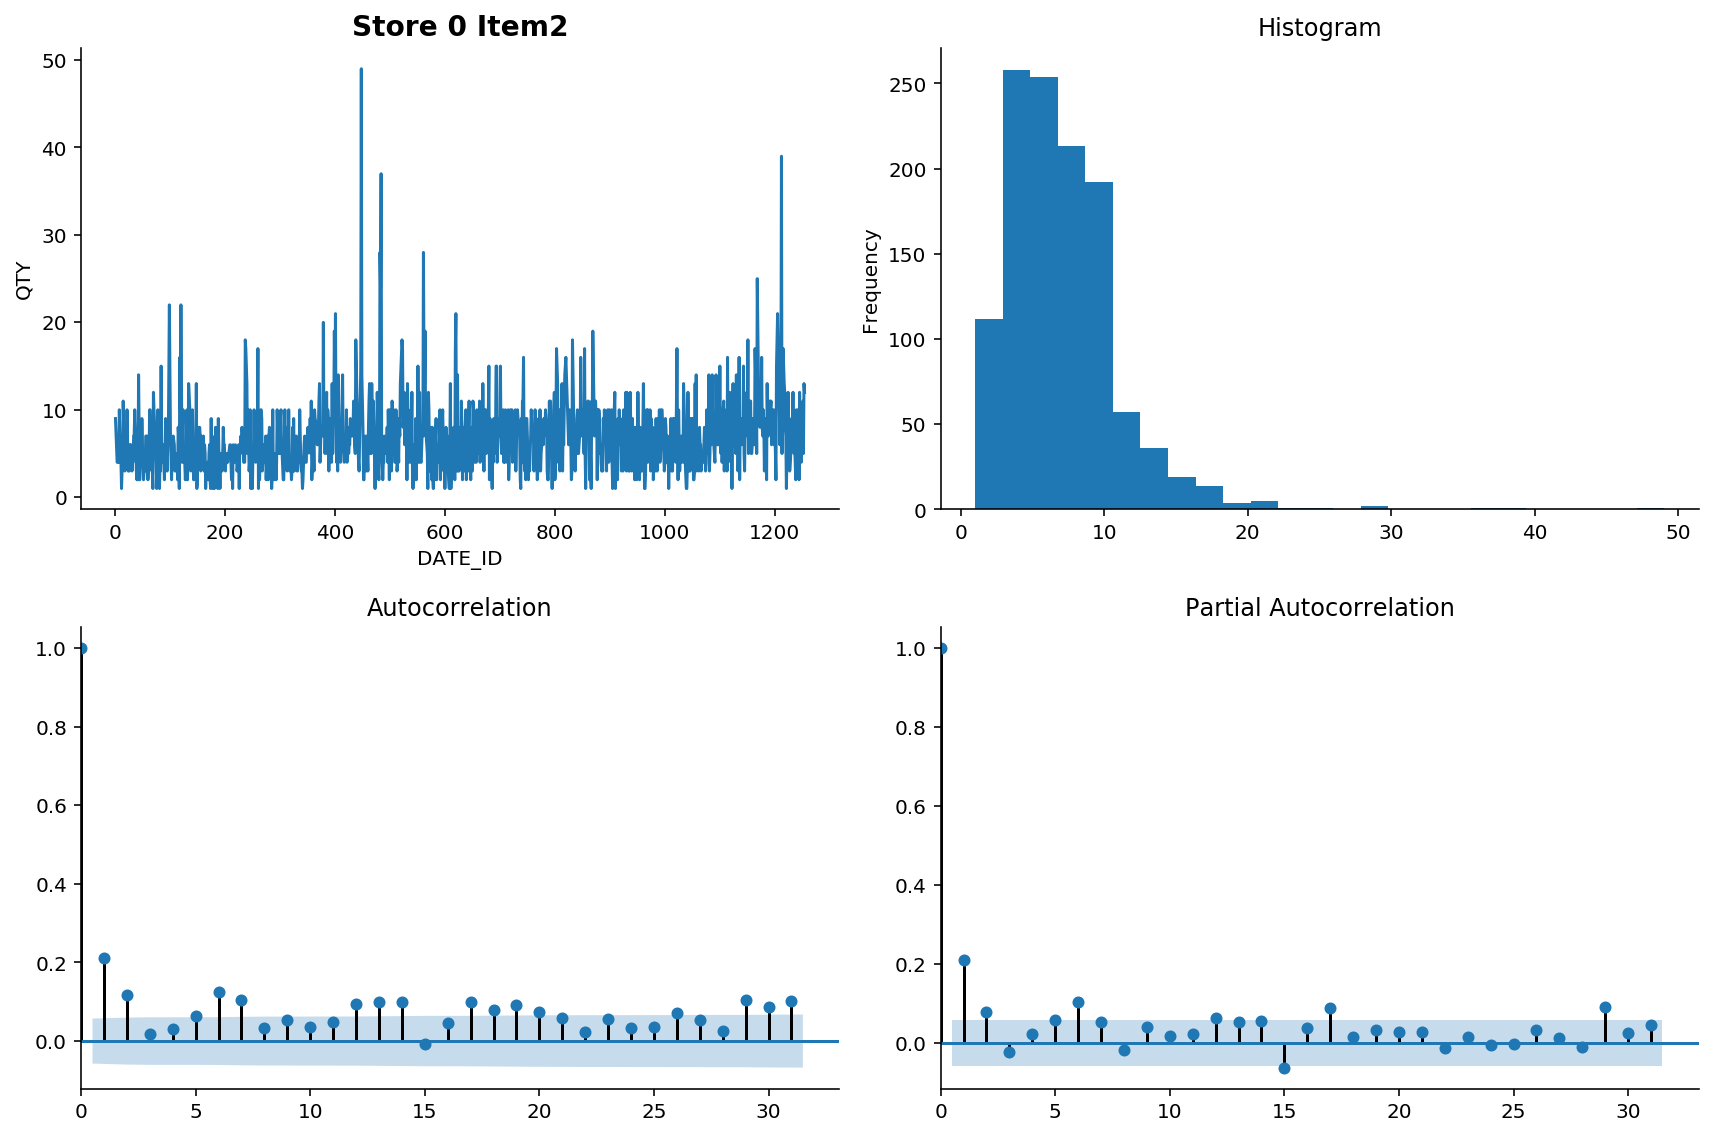

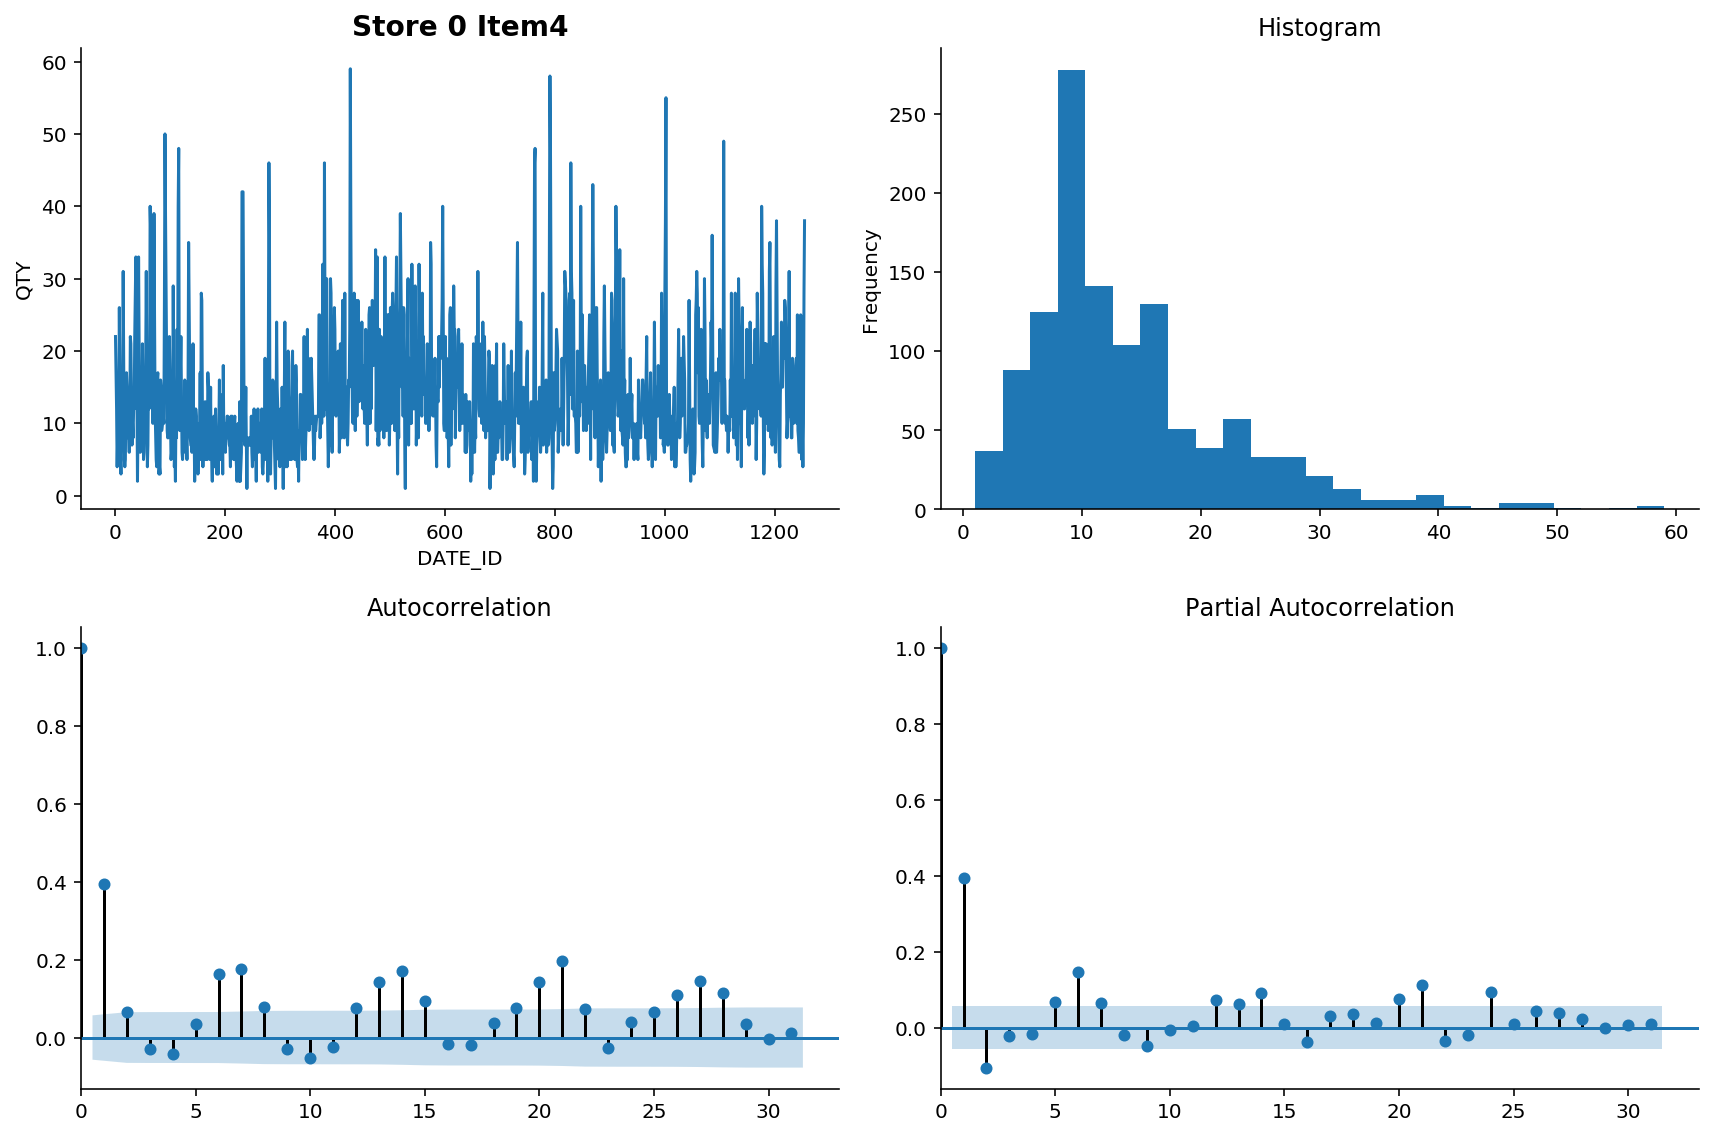

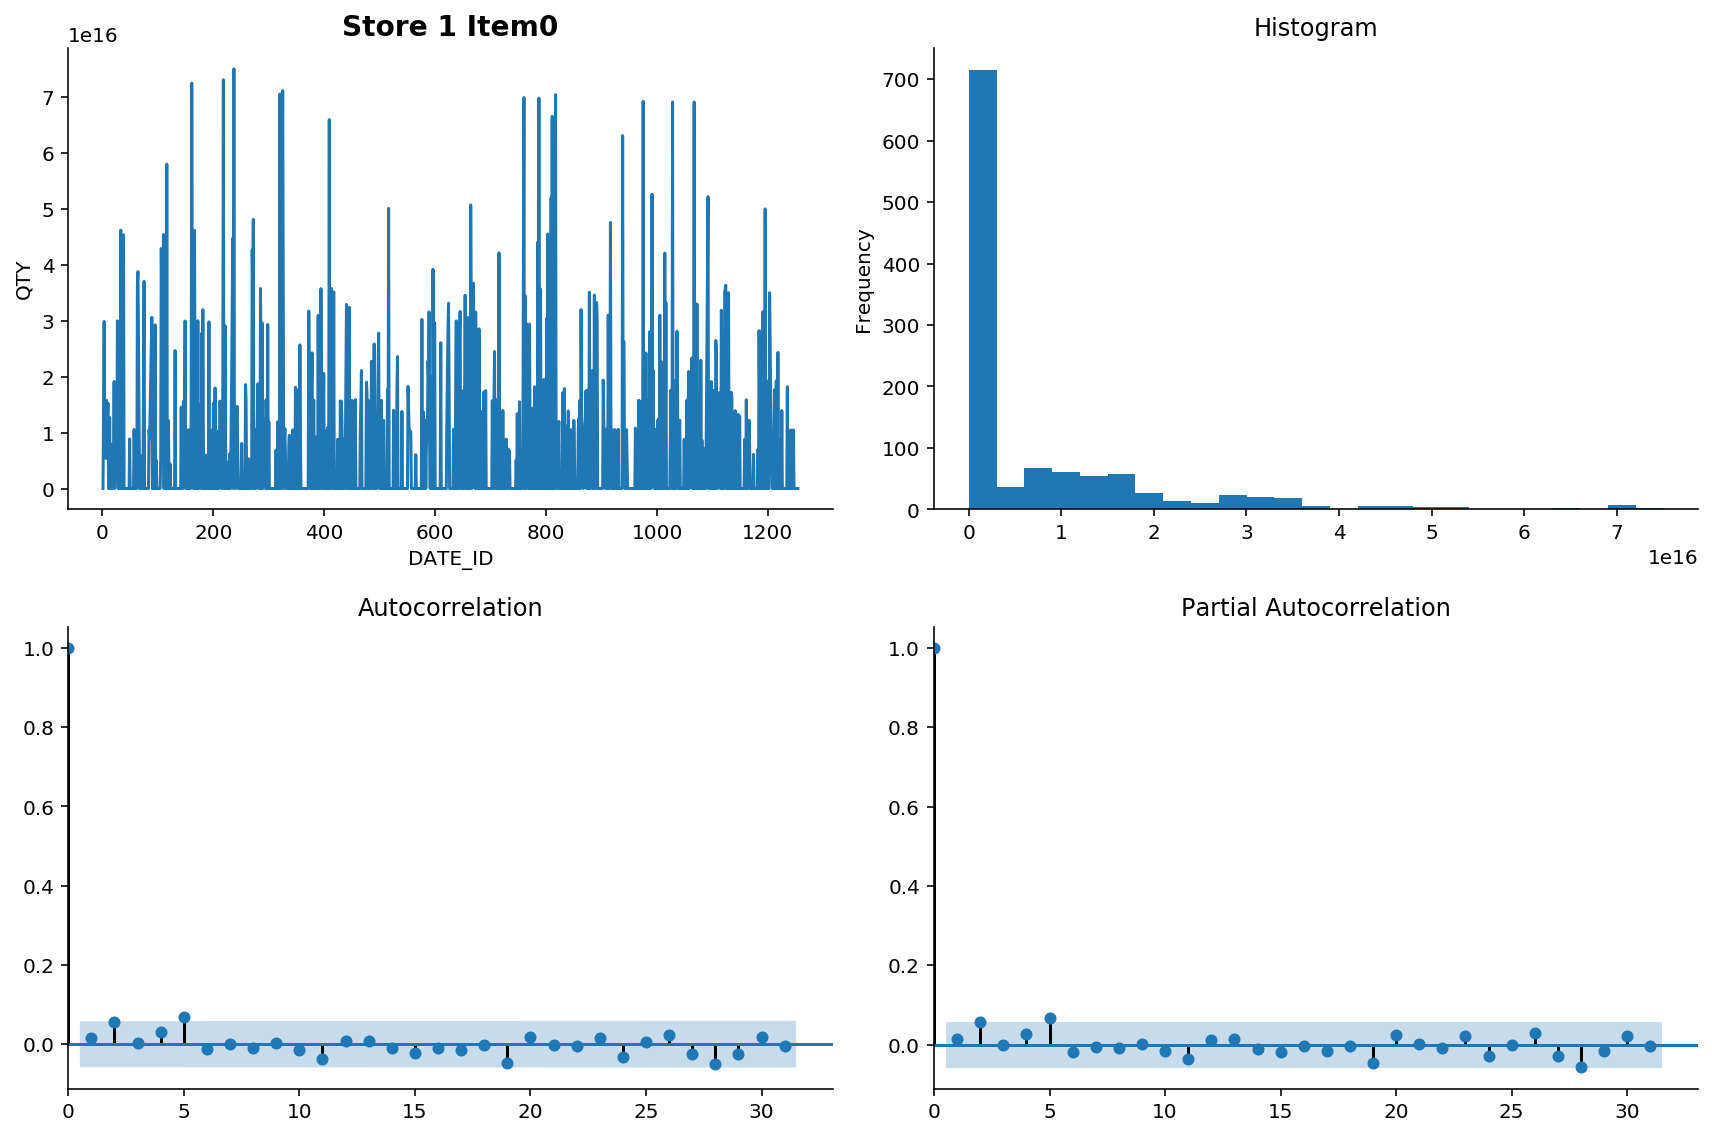

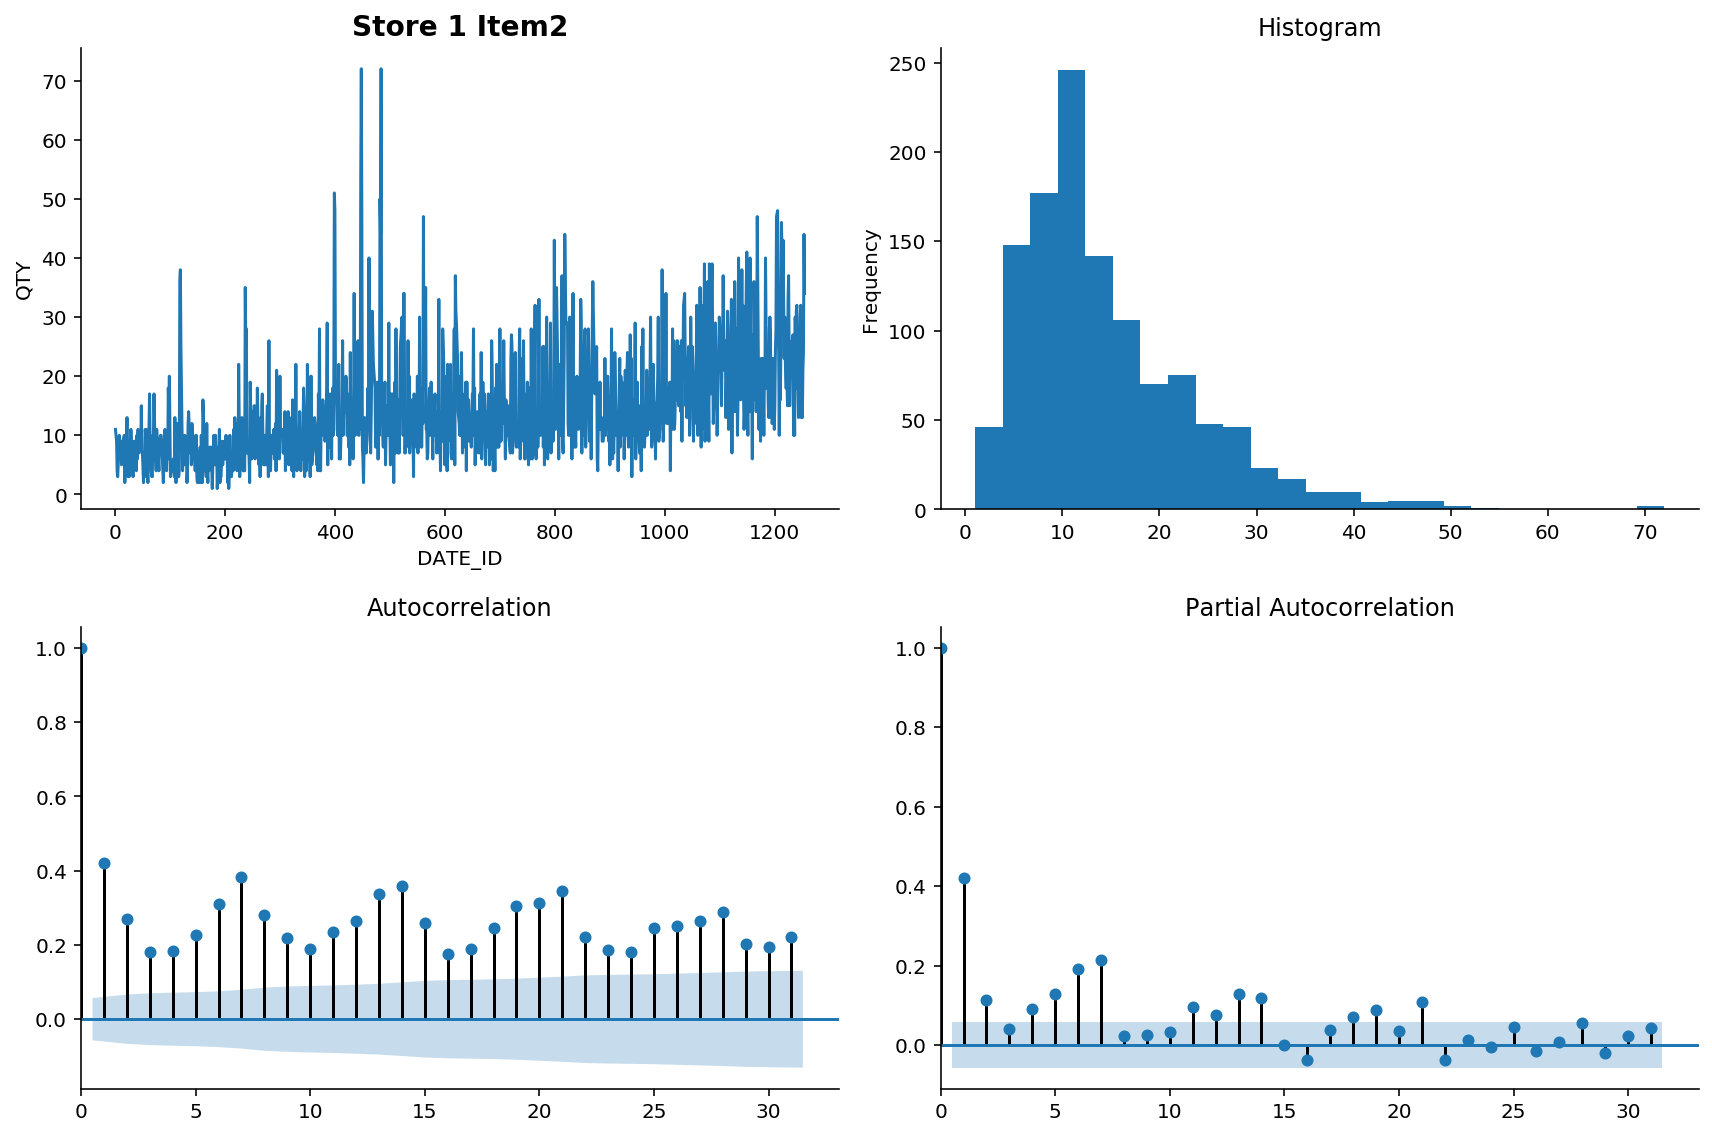

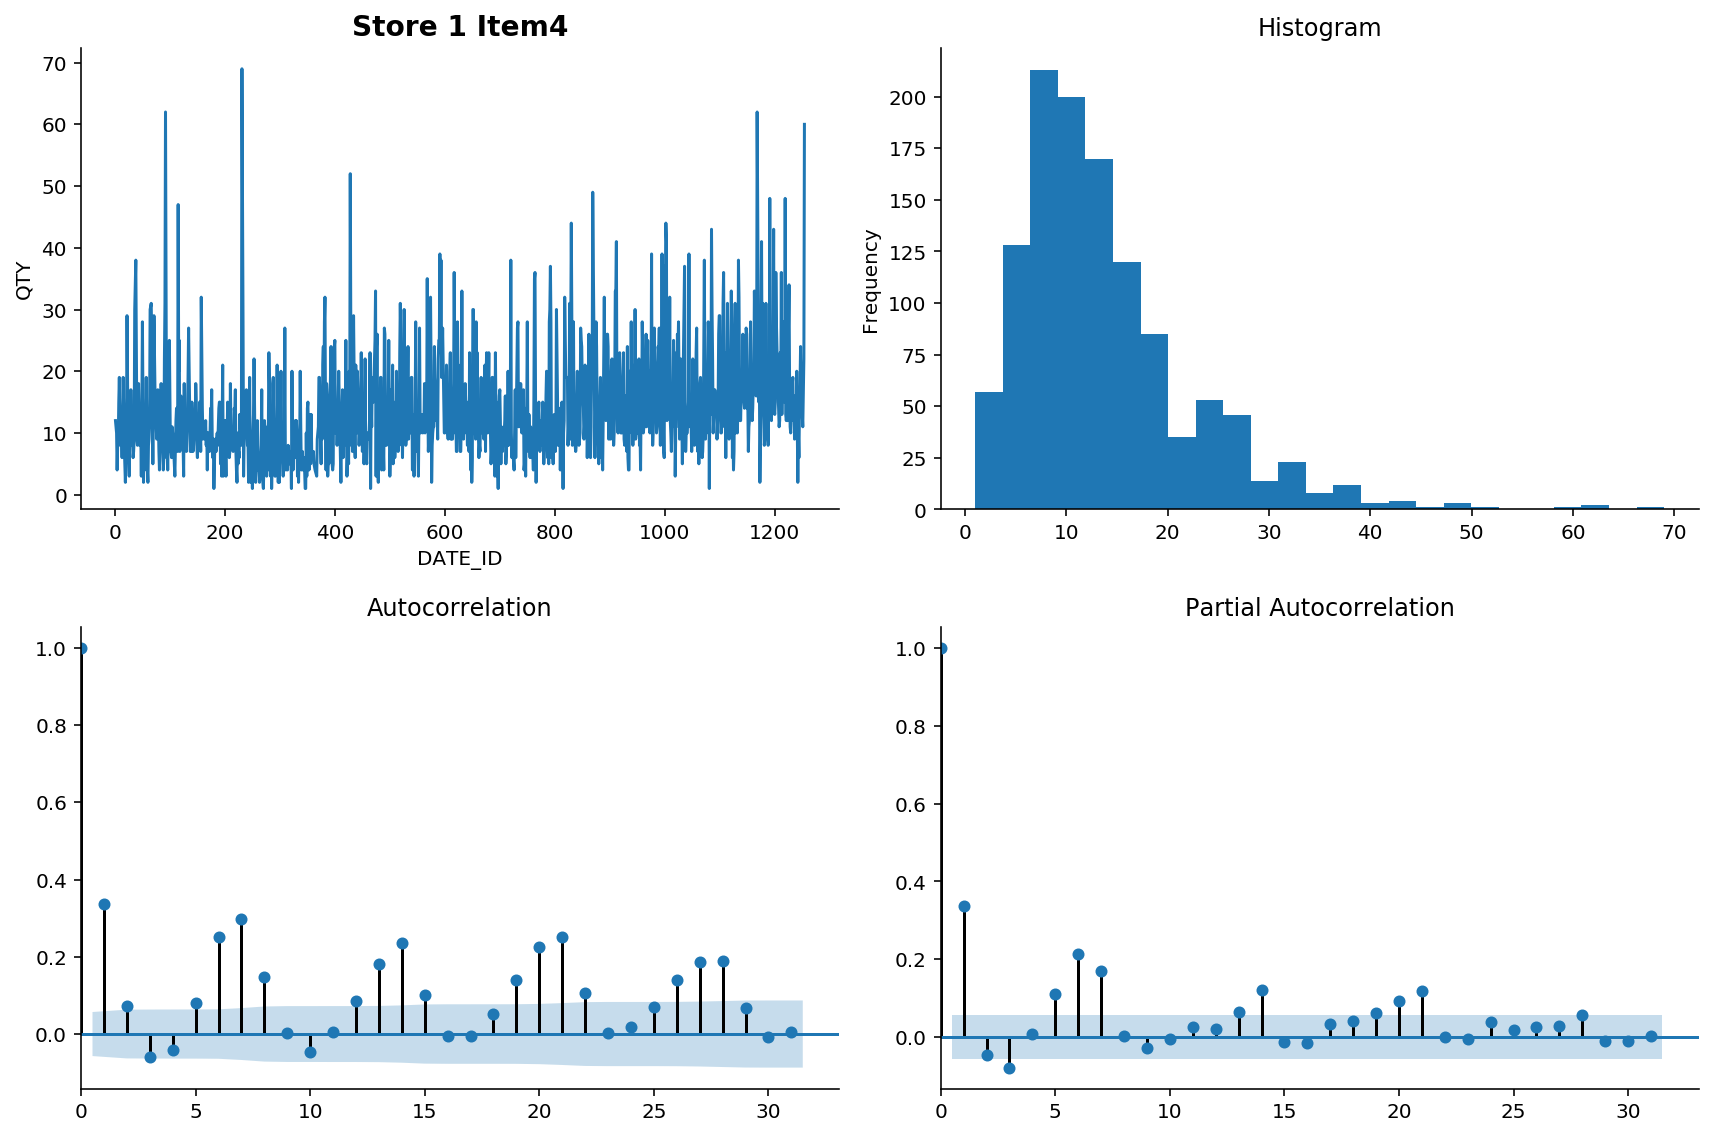

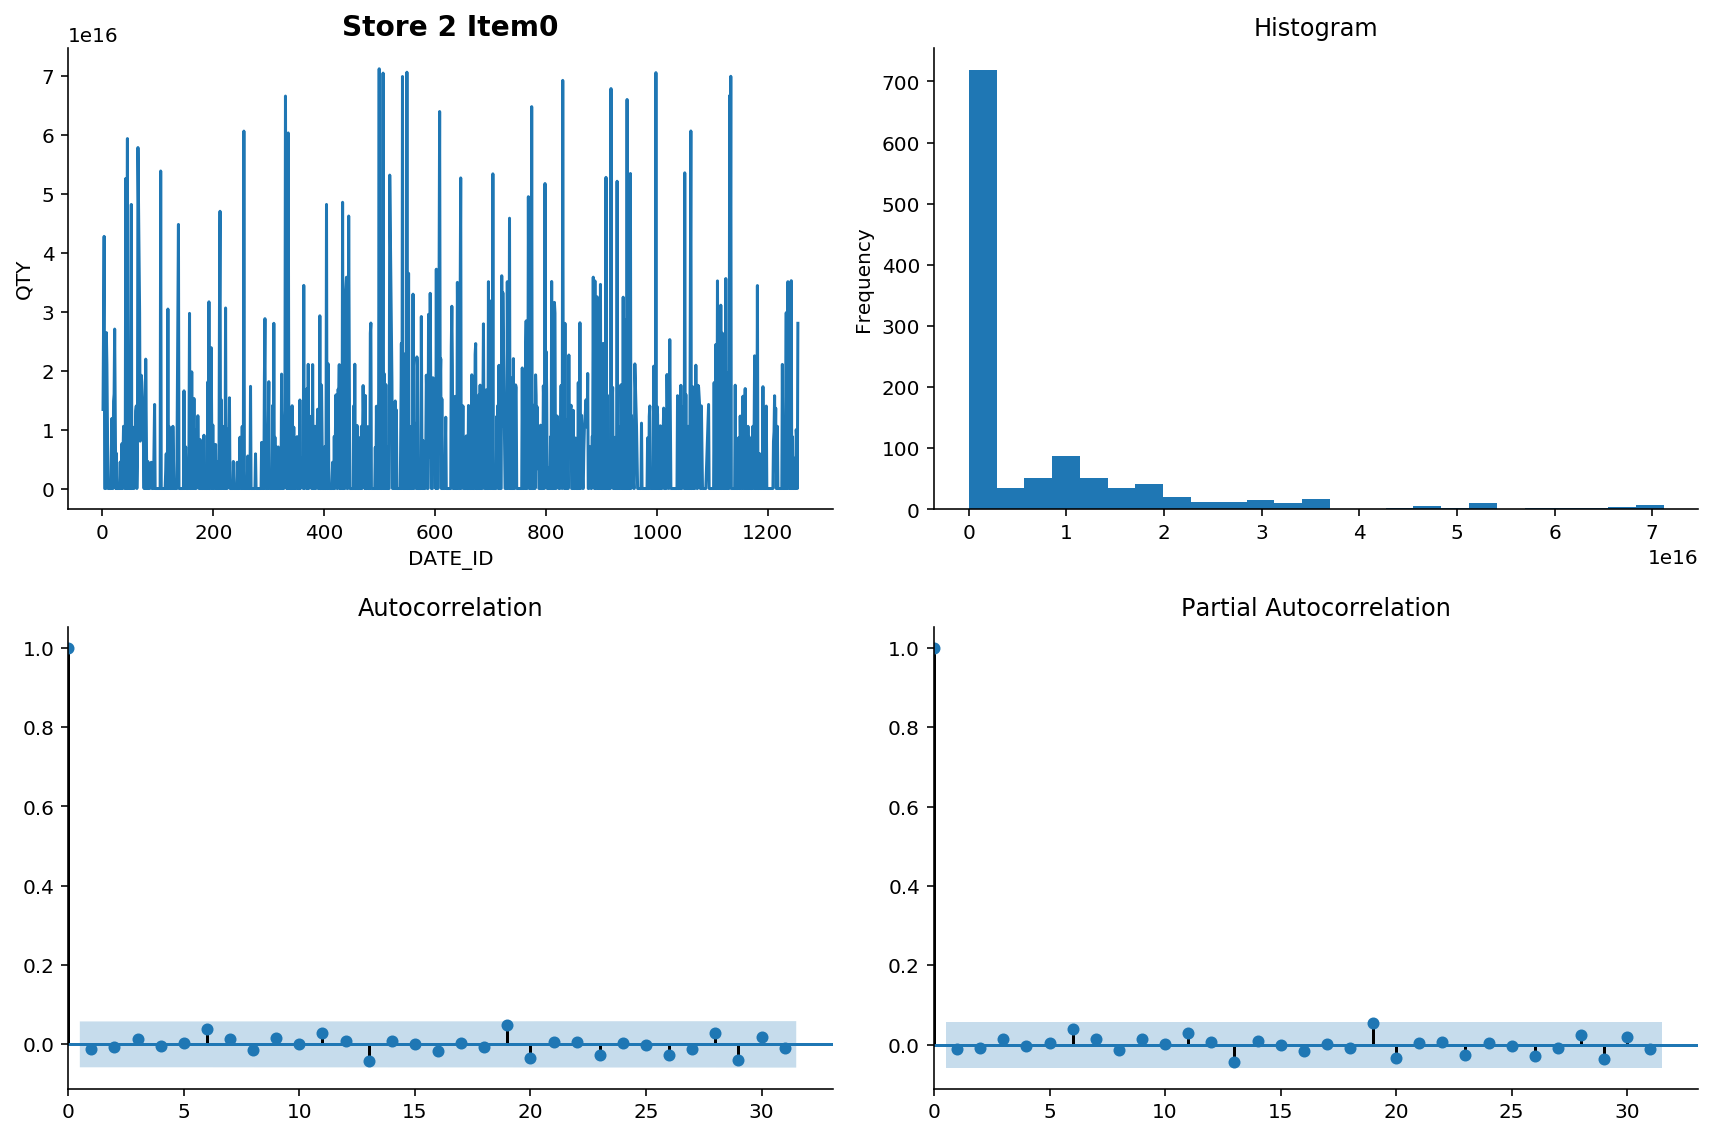

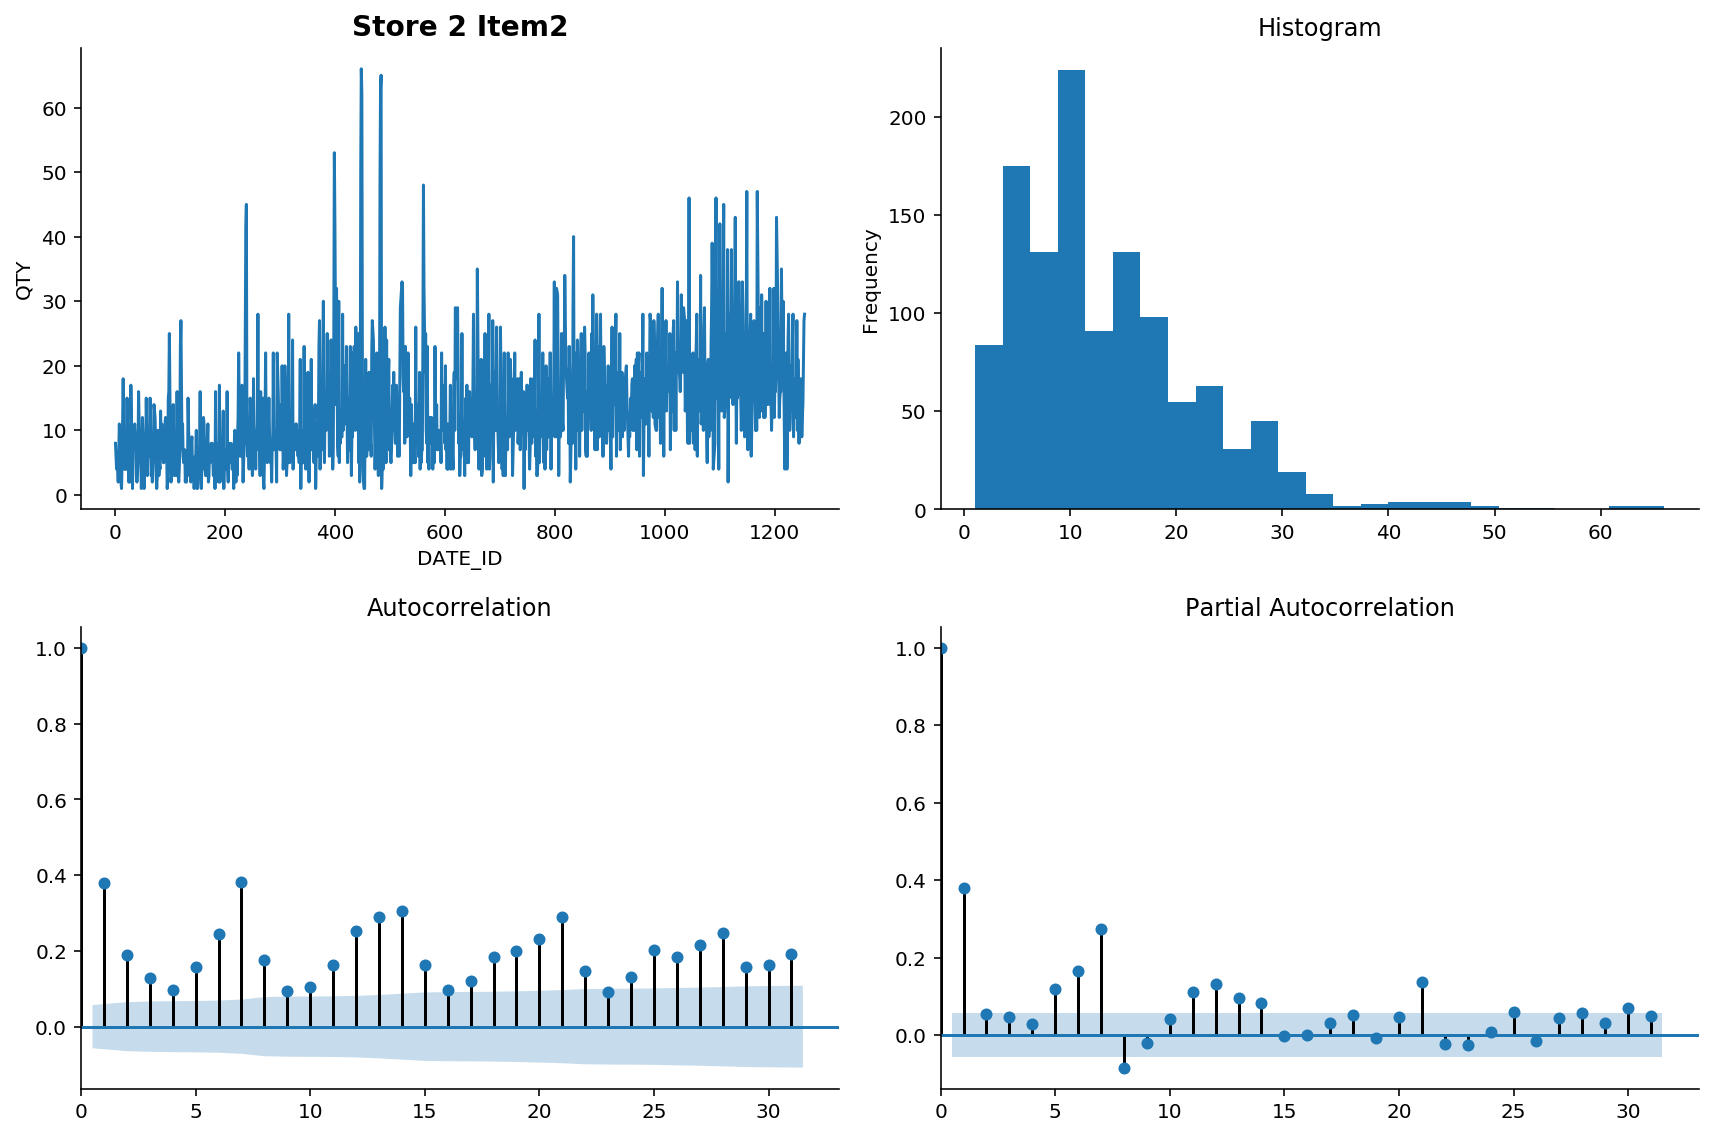

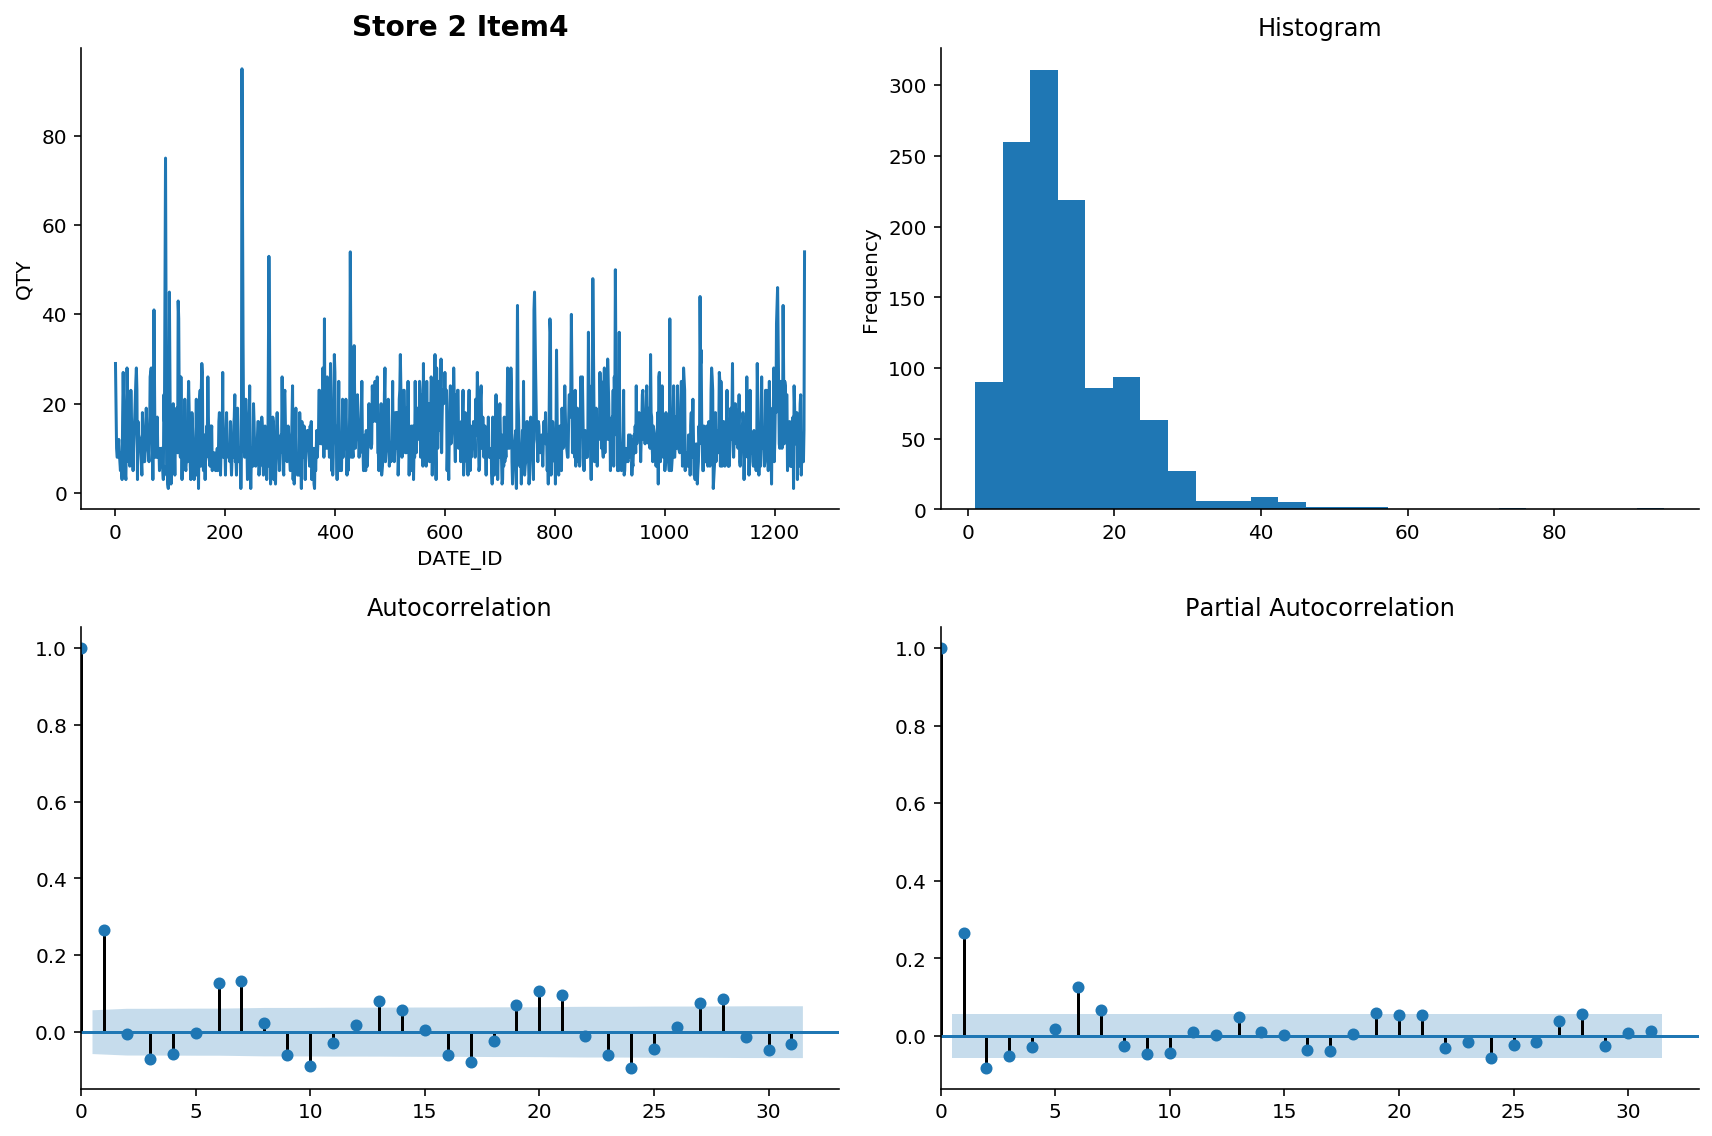

In [10]:
for store in list(df.STORE_ID.unique())[:3]:
    for item in list(df.ITEM_ID.unique())[:3]:
        
        selection = df[(df.STORE_ID == store) & (df.ITEM_ID == item)]
        tsplot(selection.DATE_ID,selection.QTY, 'Store {} Item{}'.format(int(store),int(item)))

- for some store-item combinations number of items sold shows clear autocorrelation
- distribution should be fairly normal after log-transformation
- but store-item combinations without autocorrelation as well
- log transformation wouldn't help either

### Items over time

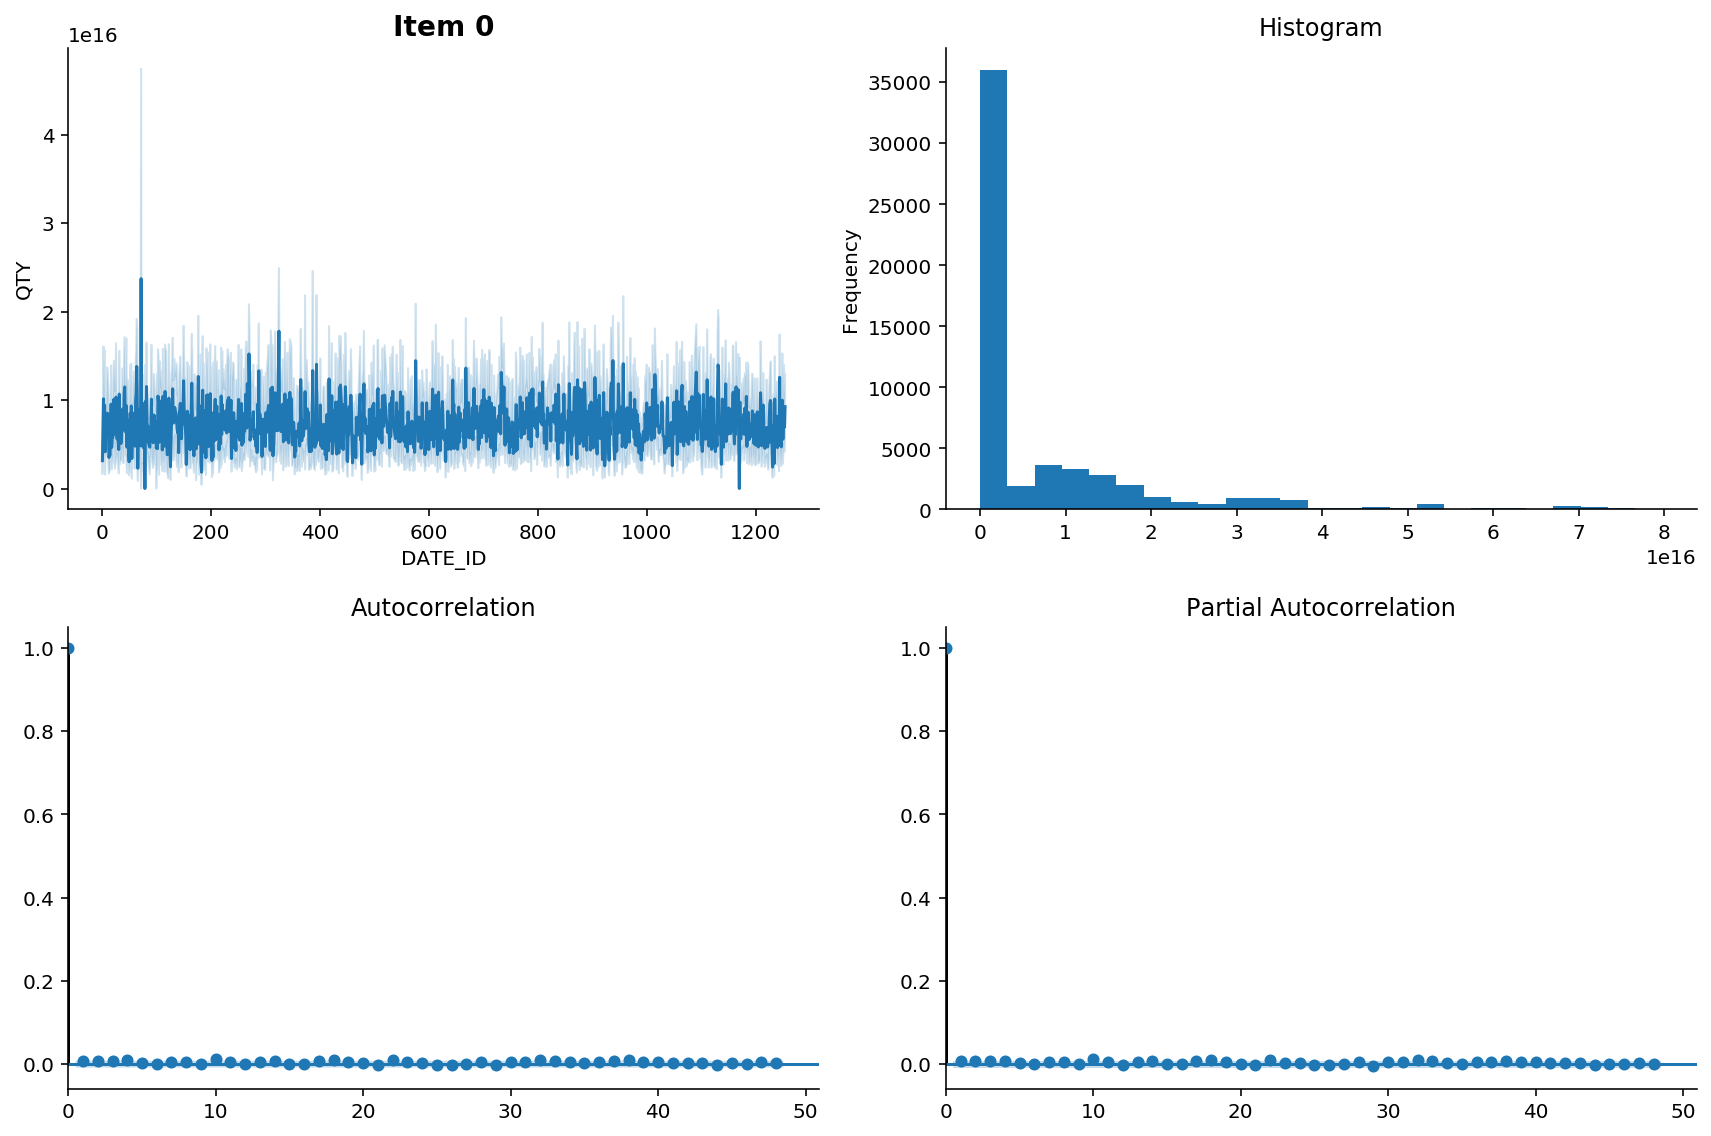

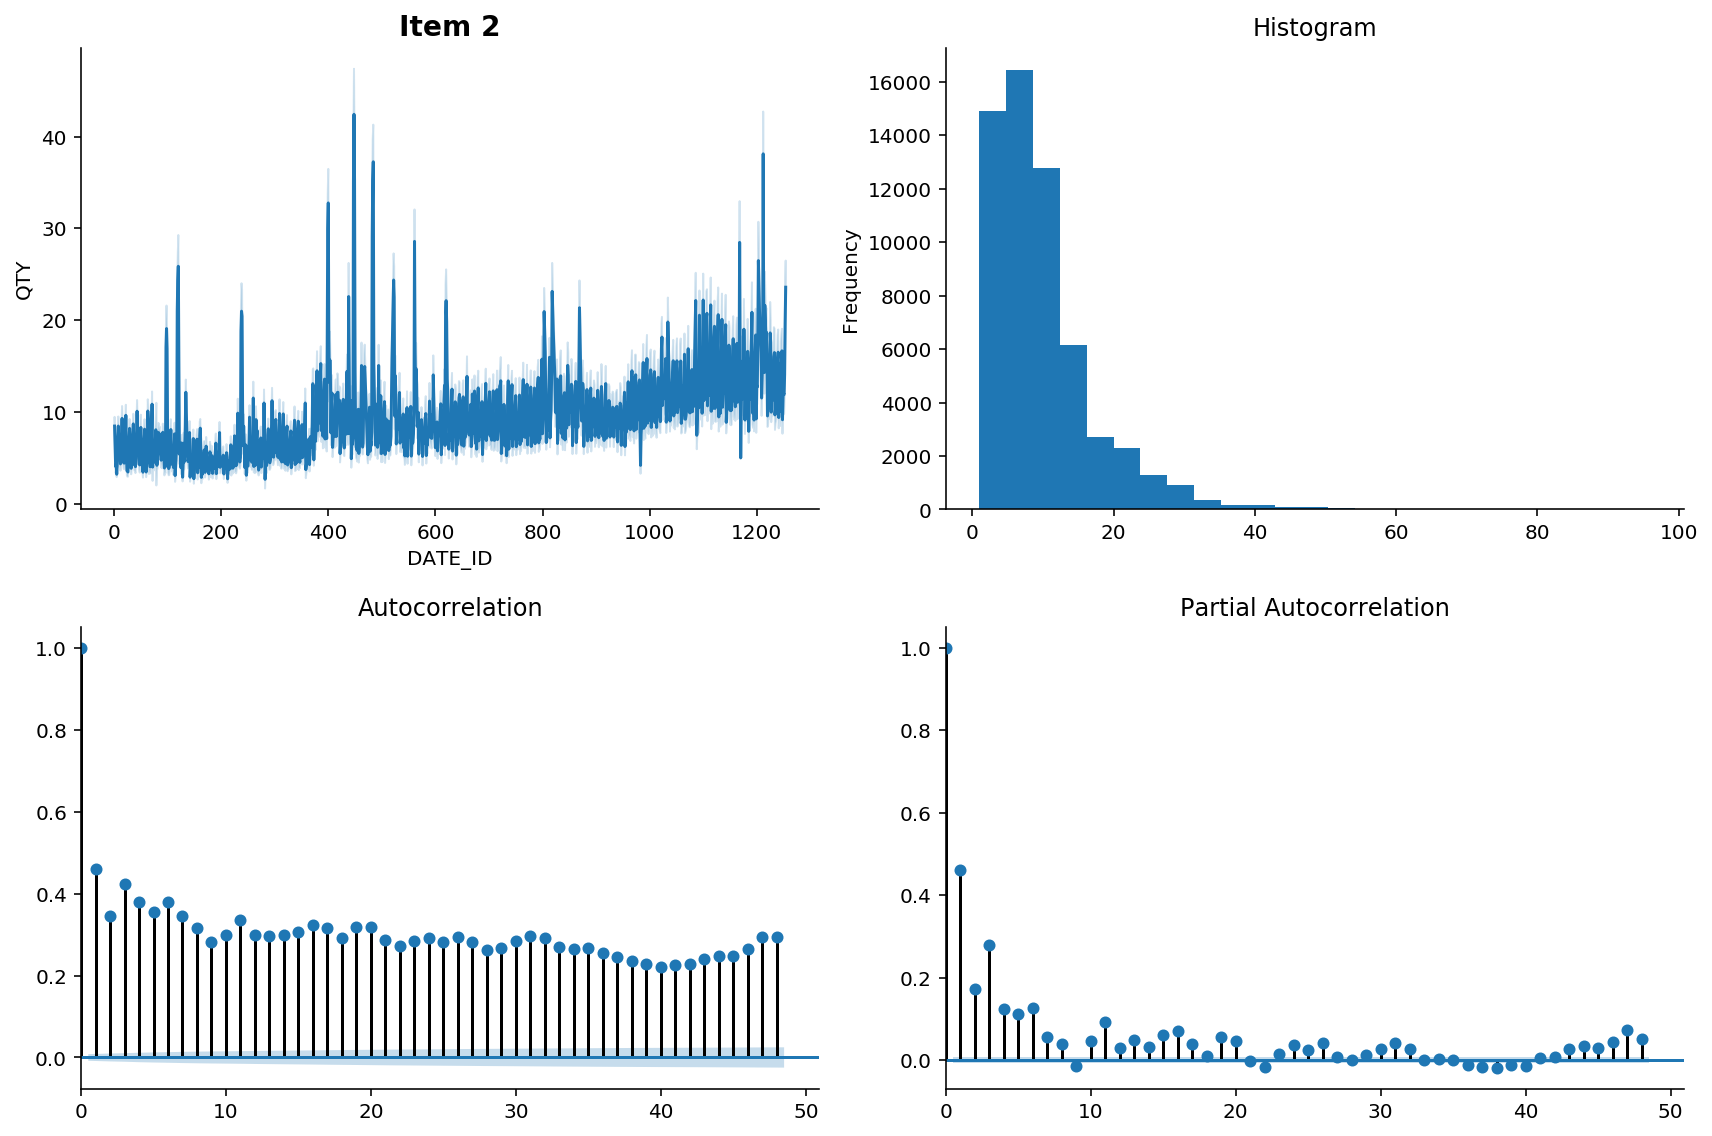

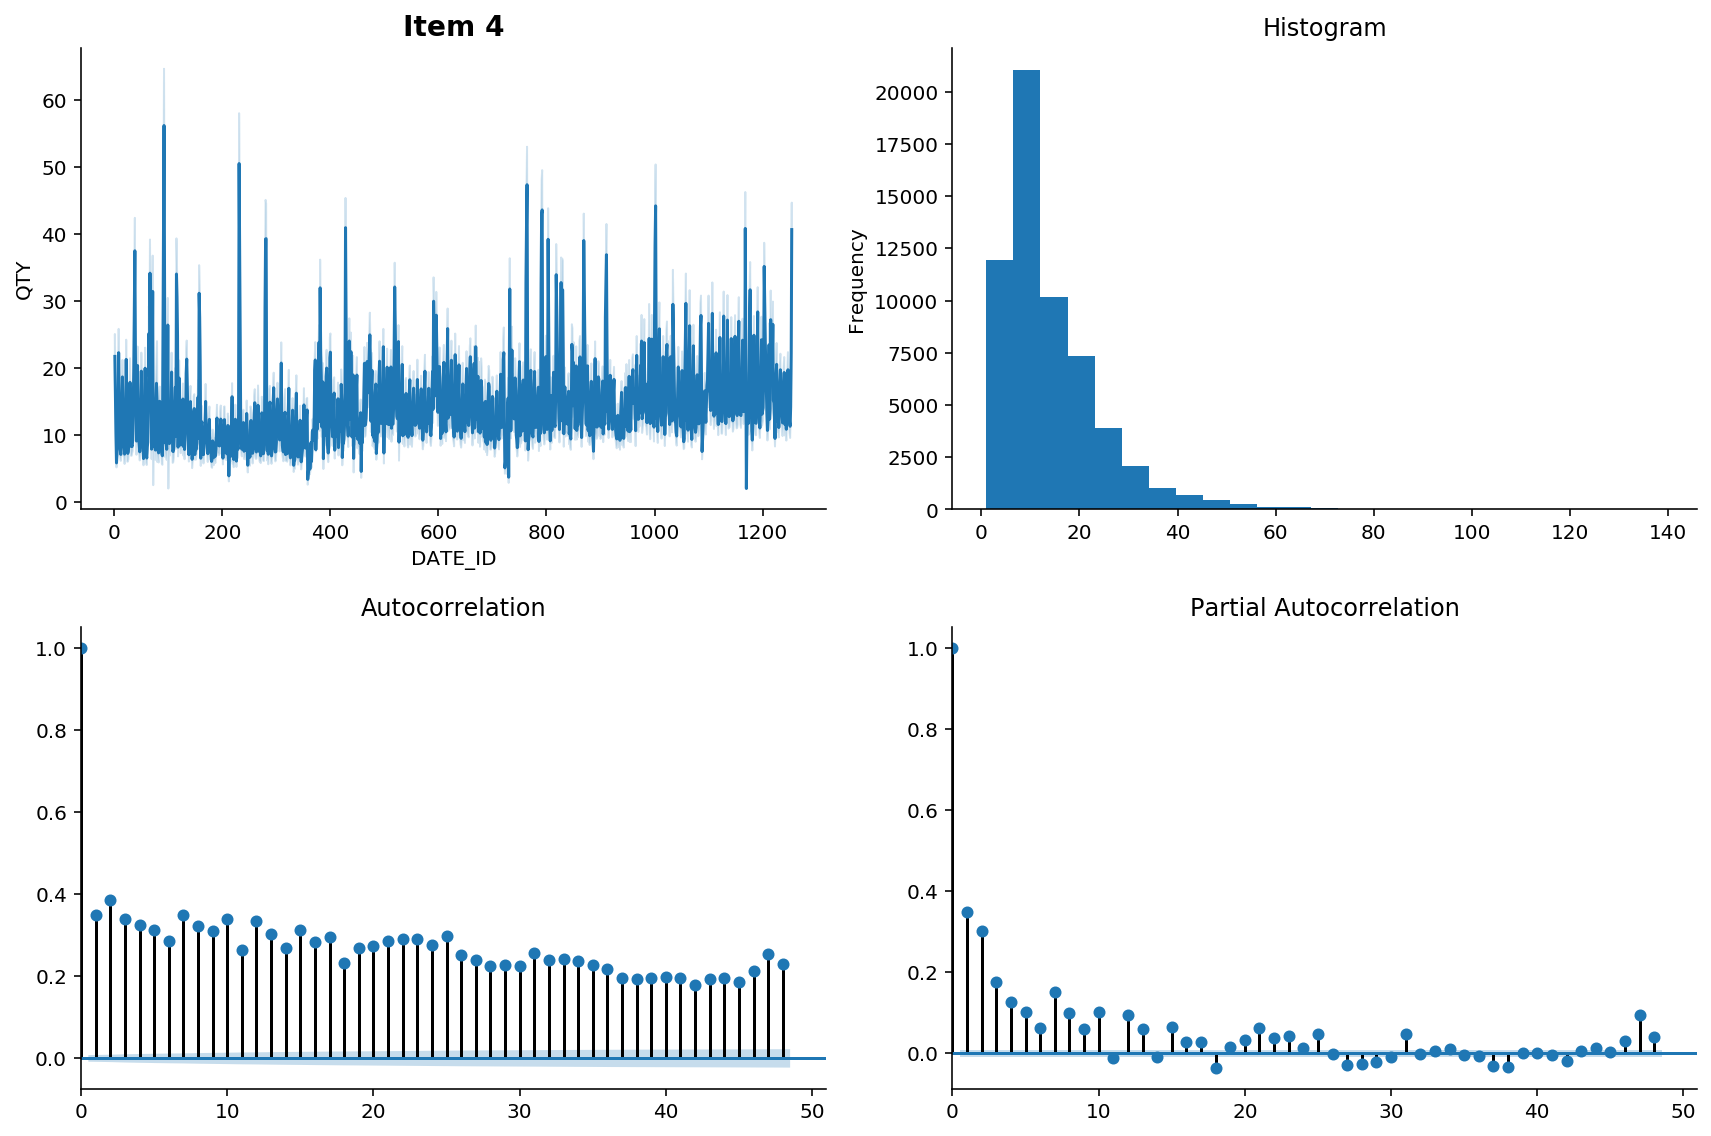

In [11]:
for item in list(df.ITEM_ID.unique())[:3]:
    selection = df[df.ITEM_ID == item]
    tsplot(selection.DATE_ID,selection.QTY, 'Item {}'.format(int(item)))

- similar results with items
- strong and weak autocorrelation
- huge gaps for item 15,8,3,1
- sometimes huge peaks over time

### Stores over time

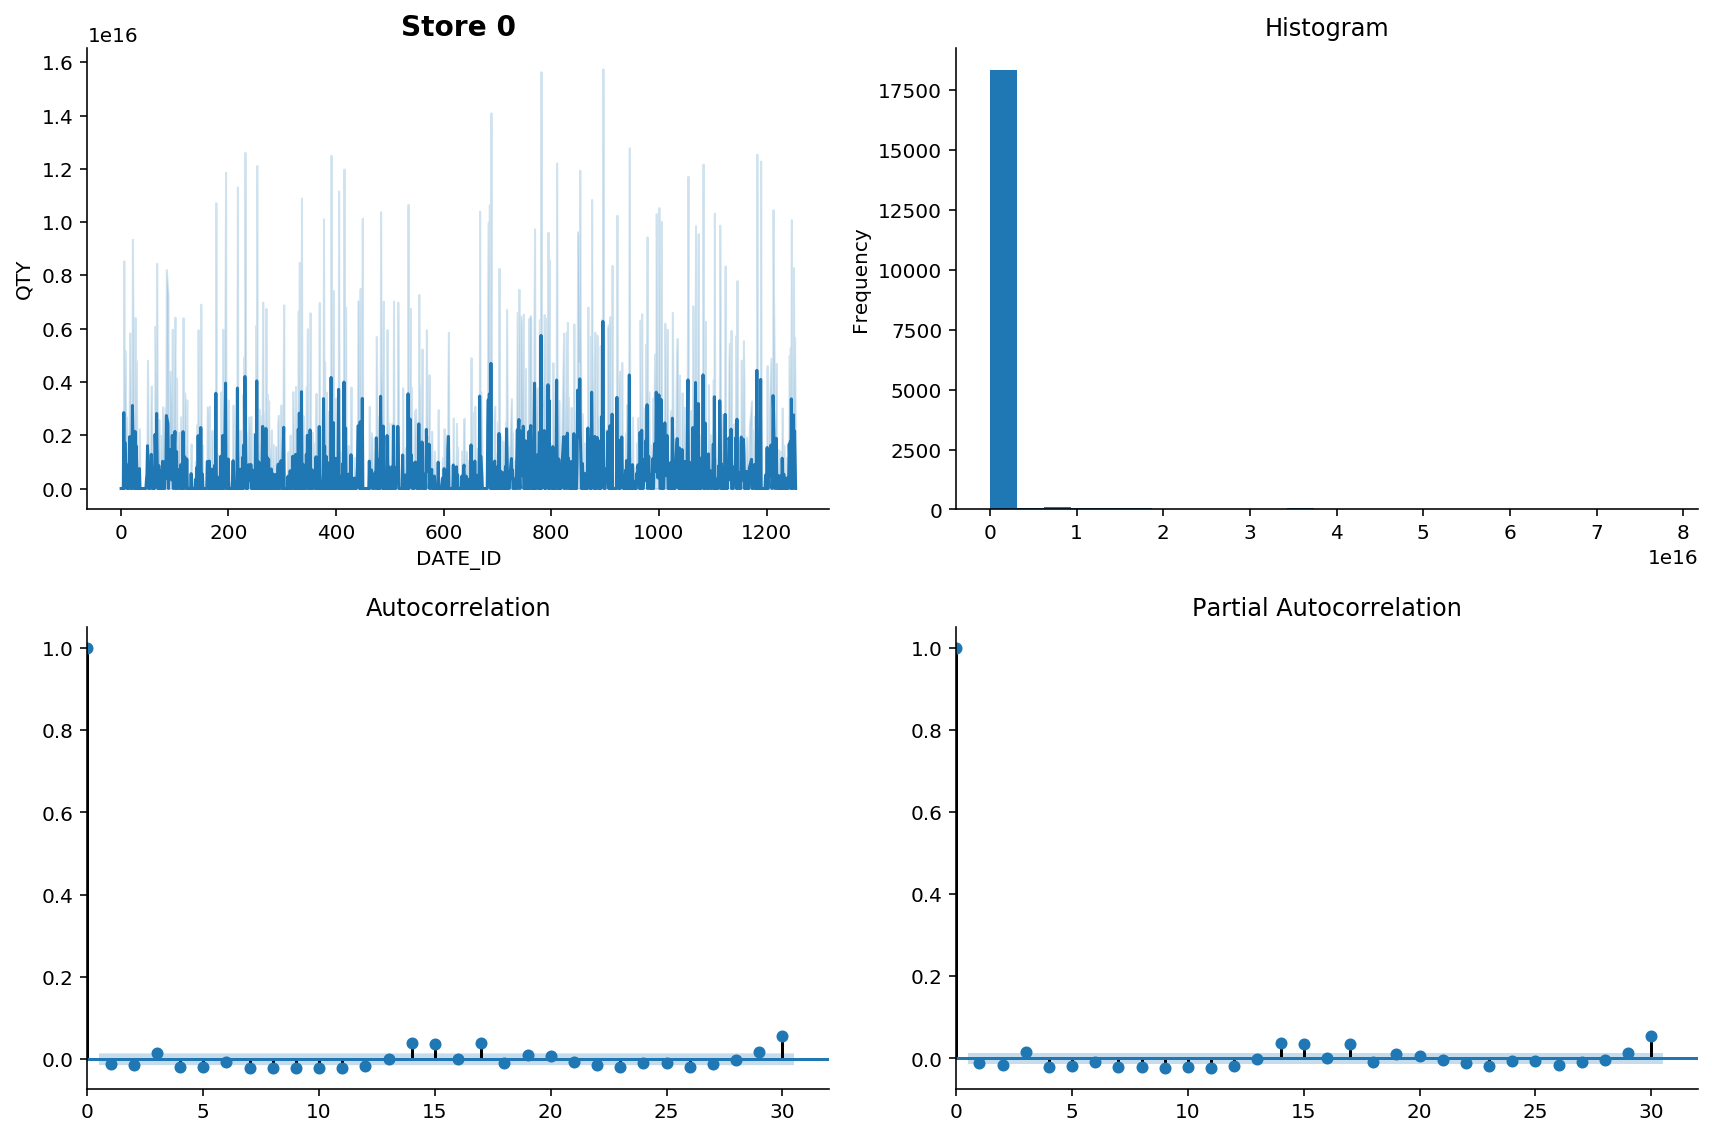

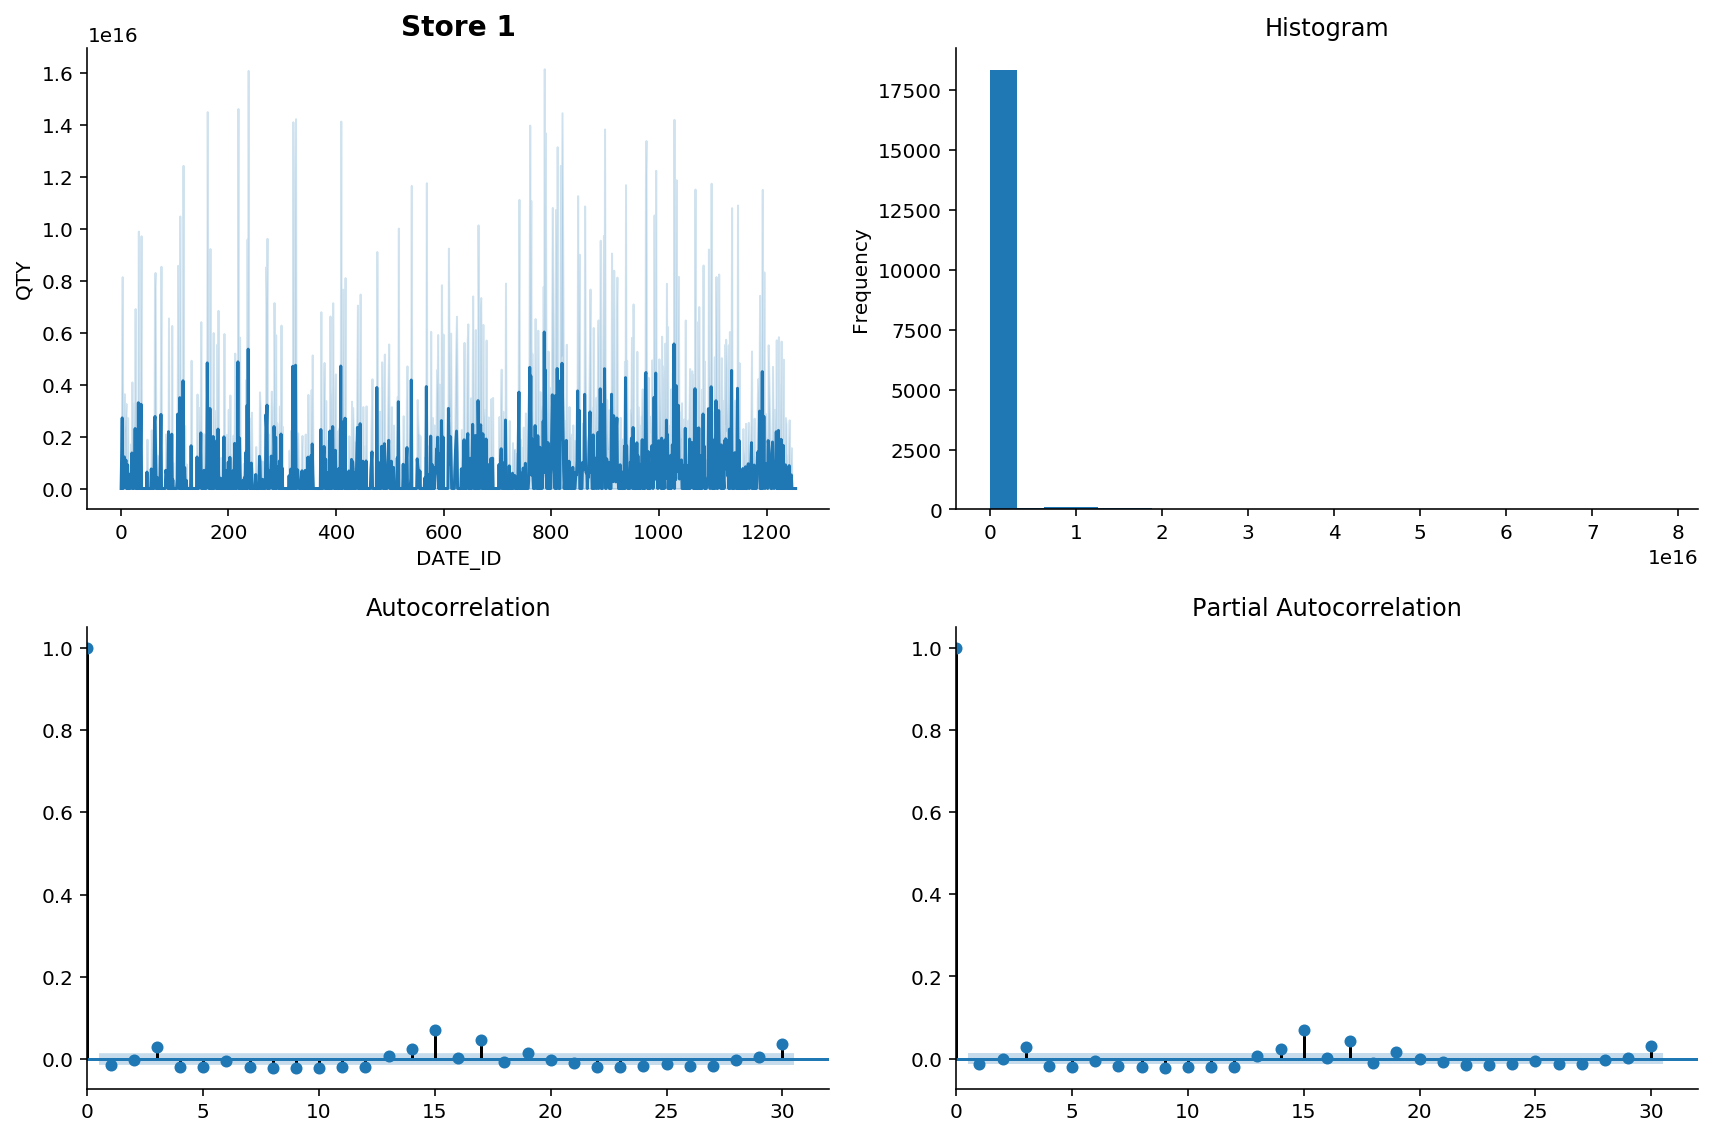

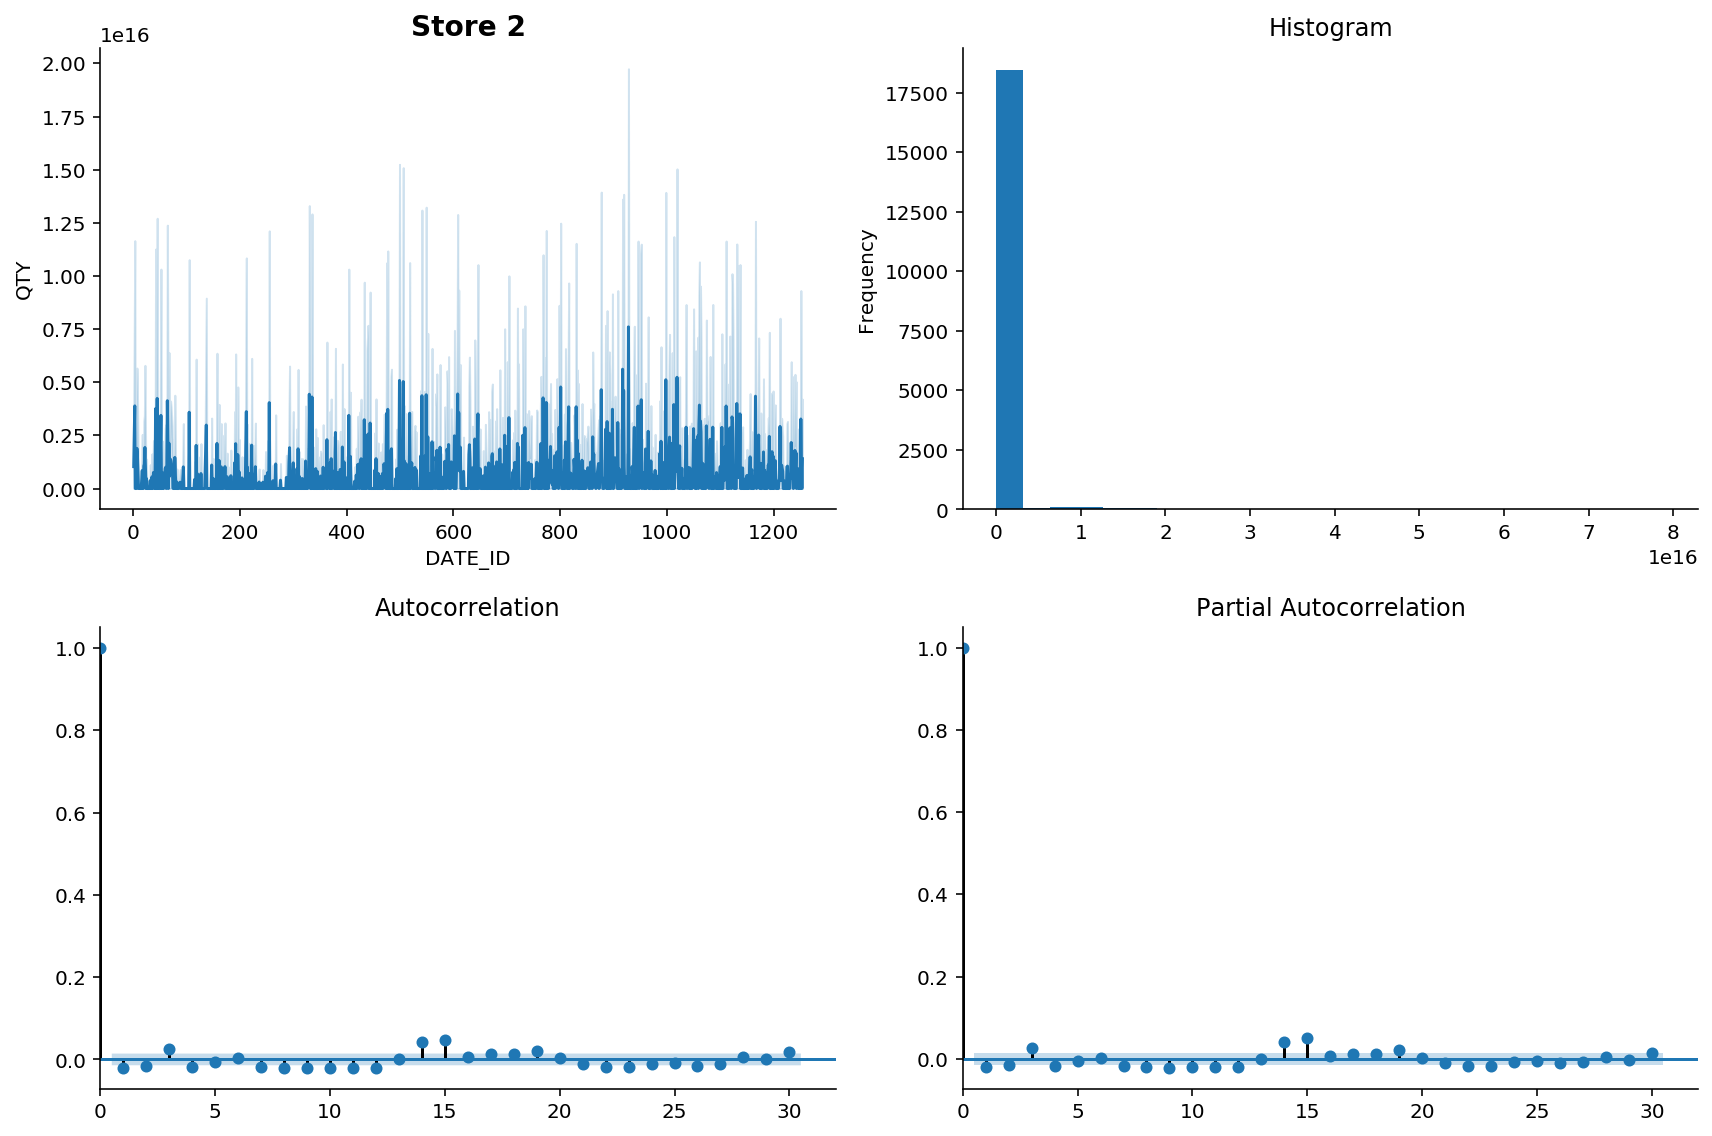

In [12]:
for store in list(df.STORE_ID.unique())[:3]:
    selection = df[df.STORE_ID == store]
    tsplot(selection.DATE_ID,selection.QTY, 'Store {}'.format(int(store)),30)

- stores alone seem to have noisy data

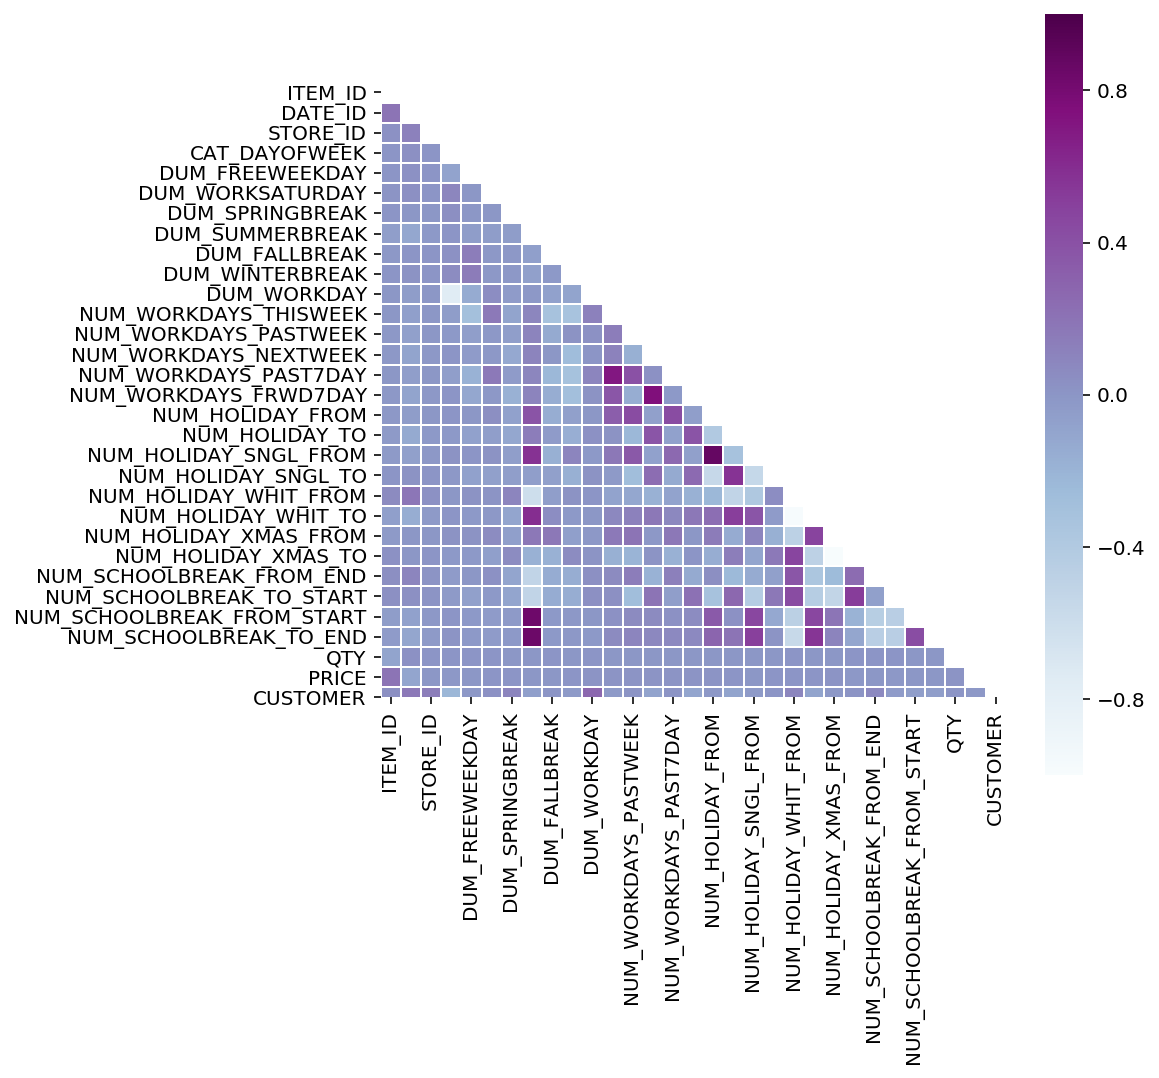

In [13]:
# Compute the correlation matrix 
corr_all = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (7, 7))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

In [14]:
corr_all['QTY'].sort_values(ascending=False)[:10]

QTY                         1.000000
DATE_ID                     0.027179
PRICE                       0.015074
NUM_HOLIDAY_XMAS_TO         0.004606
CUSTOMER                    0.004017
NUM_SCHOOLBREAK_TO_START    0.003464
STORE_ID                    0.003426
DUM_WORKSATURDAY            0.003202
NUM_HOLIDAY_WHIT_FROM       0.002617
NUM_SCHOOLBREAK_FROM_END    0.001743
Name: QTY, dtype: float64

## 3. Feature Engineering

- since we've found autocorrelation, we should include items sold in the past
- even though correlation over all (first glance) seems to be not strong, we should include price
- combinations of stores and items will determine our training data
- store-item-combinations in particular useful, because here DATE_ID can be seen a primary key
- in othere words we're not aggregating QTY and not loosing information by doing so

### Building distinct data sets for each store-item combination

In [15]:
data, outtakes = {},{}

for store in list(df.STORE_ID.unique()):
    for item in list(df.ITEM_ID.unique()):
        
        selection = df[(df.STORE_ID == store) & (df.ITEM_ID == item)]
        
        if len(selection) >= 10:
            data['df_store_{}_item_{}'.format(int(store),int(item))] = selection
        else:
            outtakes['df_store_{}_item_{}'.format(int(store),int(item))] = selection

In [16]:
print(round(len(outtakes)/len(data),5))
print(round((after - sum([len(outtakes[d]) for d in outtakes]))/before,5))

0.04788
0.97595


Roughly 5% of all combinations won't be used. However, since that are only 33 rows, we can still continue with 97.6% of our data.

To use data from previous days, we need to be sure, that its sorted.

```python 
last_x_days = 7 #Note, we could also set this dynamically depending on the amount of data.

for d in data:
    cnt += 1
    
    # In some cases dates are mixed, here it gets fixed :)
    data[d] = data[d].sort_values('DATE_ID',kind='mergesort')
```

### Feature Generation

Then we build our features opon. Note when we iterate through all QTY.values, at some point there won't be a previous day anymore. But this loop does not throw an error. Instead it starts from the beginning again until the loop is completed. That's why we need to remove last_x_days from the beginning of the data frame later.

```python
    # Creating features from historical data
    prev_rows = {}
    for num in range(1,last_x_days+1):
        prev_rows['qty_prev_{}d'.format(num)] = \
        [data[d].QTY.values[i-num] for i in range(len(data[d]))]
        prev_rows['qty_delta_{}d'.format(num)] = \
        [data[d].QTY.values[i] - data[d].QTY.values[i-num] \
         for i in range(len(data[d]))]
        prev_rows['price_prev_{}d'.format(num)] = \
        [data[d].PRICE.values[i-num] for i in range(len(data[d]))]
        prev_rows['price_delta_{}d'.format(num)] = \
        [data[d].PRICE.values[i] - data[d].PRICE.values[i-num] \
         for i in range(len(data[d]))]
        prev_rows['customer_prev_{}d'.format(num)] = \
        [data[d].CUSTOMER.values[i-num] for i in range(len(data[d]))]
        prev_rows['customer_delta_{}d'.format(num)] = \
        [data[d].CUSTOMER.values[i] - data[d].CUSTOMER.values[i-num] \
         for i in range(len(data[d]))]
 ```

 Adding our new features works straight forward. Lets delete what we don't need.
 
 ```python
    # Adding new features to dataframe
    additional_features = pd.DataFrame(prev_rows)
    for key in list(additional_features.keys()):
        data[d]['{}'.format(key)]=additional_features['{}'.format(key)].values
    del additional_features, prev_rows
 ```

As mentioned above, we have to remove the 'unreal' historical data.

```python
    # Removing first rows, since there is no 'real' historical data
    data[d]=data[d].drop(data[d][:last_x_days].index)
```

Finally we define our features. It is important not to use, what we don't know at the time of the prediction. Since our target variable is QTY, we won't use it. The same goes for CUSTOMER. But there's no need to worry. We are using the past anyway with our generated features. Last but not least we'll exclude ID columns as well.

```python
    features = [col for col in list(data[d].keys()) \
                if (col not in list(data[d].keys())[:3]) & \
               (col not in ['QTY', 'CUSTOMER'])]

```

## 4. Modeling

### Performance Metrics
What's the best model? Which hyperparameters worked best? There many different metrics to determine the quality of our predictions. For the final decision, which model to use, we'll take the Mean Absolute Error (MAE), which is nothing else than the average  of the total values of the differences of our forecasts and their related observations.

\begin{equation*}
MAE = \frac{1}{n}  \sum_{i=0}^n |forecast - observation|
\end{equation*}

There are far more metrics we could consider as well. And yet for our purposes, let's stick to this intuitive and interpretable approach.

In [17]:
def mae(model_name, trained_model, xtest, ytest, prnt = False):
    """ Returns Model Name and Mean Absolute Error."""
    yhat = trained_model.predict(xtest)
    mae = np.exp(np.mean(np.abs(yhat - ytest))) #undo log transformation for comparison
    if prnt == True:
        print('{} Performance'.format(model_name))
        print('Mean Absolute Error: {:0.4f}\n'.format(mae))
    return model_name, mae

### Data Splits & Transformations

To evaluate the performance of our predictions in later steps, we'll exclude the last 7 days sales history for each store-item combo. So we distinguih between valuation and training data. We will also need these distinct data sets in following calculations. A dictionary does the job quite well.

The shuffle() method would be an unusual task for classic time series models, since it's destroying temporal sequences and maybe underlying dependencies. Well, we already considered previous data in our feature generation. Indeed shuffle helped to improve the models performance tremendously, since it removed bias.

Also note that we are also applying a log transformation. In our exploratory data analysis we saw that distributins of QTY were (in best case) right skewed. With log we can make it almost normal and scale it as well. Note that we have to undo np.log() on our predictions later. This can be achieved with np.exp(), since $e^{ln x} = x$ if x > 0.

```python
    # Splitting data    
    df_validation = data[d][data[d].DATE_ID > data[d].DATE_ID.max()-7]
    df_training = data[d].drop(df_validation.index)
    
    trainings['df_store_{}_item_{}_old_data'\
              .format(int(data[d].STORE_ID.min()),
                      int(data[d].ITEM_ID.min()))] = df_training
    validations['df_store_{}_item_{}_new_data'\
                .format(int(data[d].STORE_ID.min()),
                        int(data[d].ITEM_ID.min()))] = df_validation
    
    X,y = shuffle(df_training, np.log(df_training.QTY), random_state = seed)
    del df_validation,df_training
```

Here we use 'try:' out of stability considerations, even though this is a prototype not ready for production yet. The second data split is meant for training and quick evaluation purposes.
```python
    # Some Store-Item Combinations throw errors due to insufficient data, 
    # we can handle them later
    try:
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size = 0.2, random_state = seed)
```

### Used Models

The scikit-learn Powerhouse offers a lot of machine learning tools and models with a high performance out of the shelf already with default settings. We are trying to predict the continuous variable QTY. So it's a regression problem. Famous models, also often used in Kaggle competitions are the GradientBoostingRegressor() and the RandomForestRegressor(). For 'simplicity' we'll stick to only two models. However, the dictionary 'models' could be extended.

#### Gradient Boosting Regressor

The Gradient Boosting Regressor is an additive decision tree model which combines 'weak' predictions of a fixed number of trees (n_estimators) with each other. With each iteration it tries to minimize the loss (default: Least Squares method) using Gradient Descent. 

#### Random Forest Regressor

In its default settings this model builds a bootstrapped dataset (sampling with replacement). From this dataset it builds a fixed number of decision tree models (by default n_estimator=10) with randomly picked samples (rows) and randomly picked features (columns). The prediction of new data is then based on the mean prediction (for regression problems).

```python
        models = {'GradientBoostingRegressor': 
                  GradientBoostingRegressor(random_state=seed),
                  'RandomForestRegressor': 
                  RandomForestRegressor(random_state=seed)}
```

### Training

We simply train all models in a loop and store them in another dictionary. Note that this procedure could then also be extended with RandomizedSearchCV() and/or GridSearchCV() for an even better performance.

```python
        models_trained = {}
        for model in models:
            models_trained[model+'_default'] = \
            models[model].fit(X_train[features],y_train)
```

### Model selection

Since we have one simple metric, we simply use the model with the lowest error on test predictions and store it in the 'results' dictionary for predictions on new data and later evaluation.

```python
        # Model selection based on lowest error
        performance = {}
        for model in models_trained:
            evaluation = mae(model, 
                             models_trained[model] , 
                             X_test[features], 
                             y_test)
            performance[evaluation[0]] = [evaluation[1]]

        best_model = min(performance, key=performance.get), 
                     models_trained[min(performance, 
                                        key=performance.get)]
        
        results['{}'.format(d)] = [best_model[0],
                                   best_model[1],
                                   min(performance.values())[0]]
```

### Training loop execution

In [18]:
trainings, validations, results= {},{},{}
cnt = 0

last_x_days = 7 #Note, we could also set this dynamically depending on the amount of data.

for d in data:
    cnt += 1
    
    # In some cases dates are mixed, here it gets fixed :)
    data[d] = data[d].sort_values('DATE_ID',kind='mergesort')
    
    # Creating features from historical data
    prev_rows = {}
    for num in range(1,last_x_days+1):
        prev_rows['qty_prev_{}d'.format(num)] = [data[d].QTY.values[i-num] for i in range(len(data[d]))]
        prev_rows['qty_delta_{}d'.format(num)] = [data[d].QTY.values[i] - data[d].QTY.values[i-num] for i in range(len(data[d]))]
        prev_rows['price_prev_{}d'.format(num)] = [data[d].PRICE.values[i-num] for i in range(len(data[d]))]
        prev_rows['price_delta_{}d'.format(num)] = [data[d].PRICE.values[i] - data[d].PRICE.values[i-num] for i in range(len(data[d]))]
        prev_rows['customer_prev_{}d'.format(num)] = [data[d].CUSTOMER.values[i-num] for i in range(len(data[d]))]
        prev_rows['customer_delta_{}d'.format(num)] = [data[d].CUSTOMER.values[i] - data[d].CUSTOMER.values[i-num] for i in range(len(data[d]))]
    
    # Adding new features to dataframe
    additional_features = pd.DataFrame(prev_rows)
    for key in list(additional_features.keys()):
        data[d]['{}'.format(key)]=additional_features['{}'.format(key)].values
    del additional_features, prev_rows
    
    # Removing first rows, since there is no 'real' historical data
    data[d]=data[d].drop(data[d][:last_x_days].index)
    
    features = [col for col in list(data[d].keys()) if (col not in list(data[d].keys())[:3]) & (col not in ['QTY', 'CUSTOMER'])]
    
    # Splitting data    
    df_validation = data[d][data[d].DATE_ID > data[d].DATE_ID.max()-7]
    df_training = data[d].drop(df_validation.index)
    
    trainings['df_store_{}_item_{}_old_data'.format(int(data[d].STORE_ID.min()),int(data[d].ITEM_ID.min()))] = df_training
    validations['df_store_{}_item_{}_new_data'.format(int(data[d].STORE_ID.min()),int(data[d].ITEM_ID.min()))] = df_validation
    
    X,y = shuffle(df_training, np.log(df_training.QTY), random_state = seed)
    del df_validation,df_training
    
    # Some Store-Item Combinations throw errors due to insufficient data, we can handle them later
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

        models = {'GradientBoostingRegressor': GradientBoostingRegressor(random_state=seed),
                  'RandomForestRegressor': RandomForestRegressor(random_state=seed)}

        models_trained = {}
        for model in models:
            models_trained[model+'_default'] = models[model].fit(X_train[features],y_train)
        
        # Tuning could be added here
        # CODE
        
        # Model selection based on lowest error
        performance = {}
        for model in models_trained:
            evaluation = mae(model, models_trained[model] , X_test[features], y_test)
            performance[evaluation[0]] = [evaluation[1]]

        best_model = min(performance, key=performance.get), models_trained[min(performance, key=performance.get)]
        
        results['{}'.format(d)] = [best_model[0],best_model[1],min(performance.values())[0]]
    
    except: outtakes['df_store_{}_item_{}_loop'.format(int(data[d].STORE_ID.min()),int(data[d].ITEM_ID.min()))] = data[d]
    
#     print(round(cnt/len(data)*100,1),'% completed')

## 5. Diagnosis & Forecasting

#### How much data did we loose?

In [19]:
print(round(len(outtakes)/len(data),5))
print(round((after - sum([len(outtakes[d]) for d in outtakes]))/before,5))

0.05019
0.97594


#### How far off are our predictions?

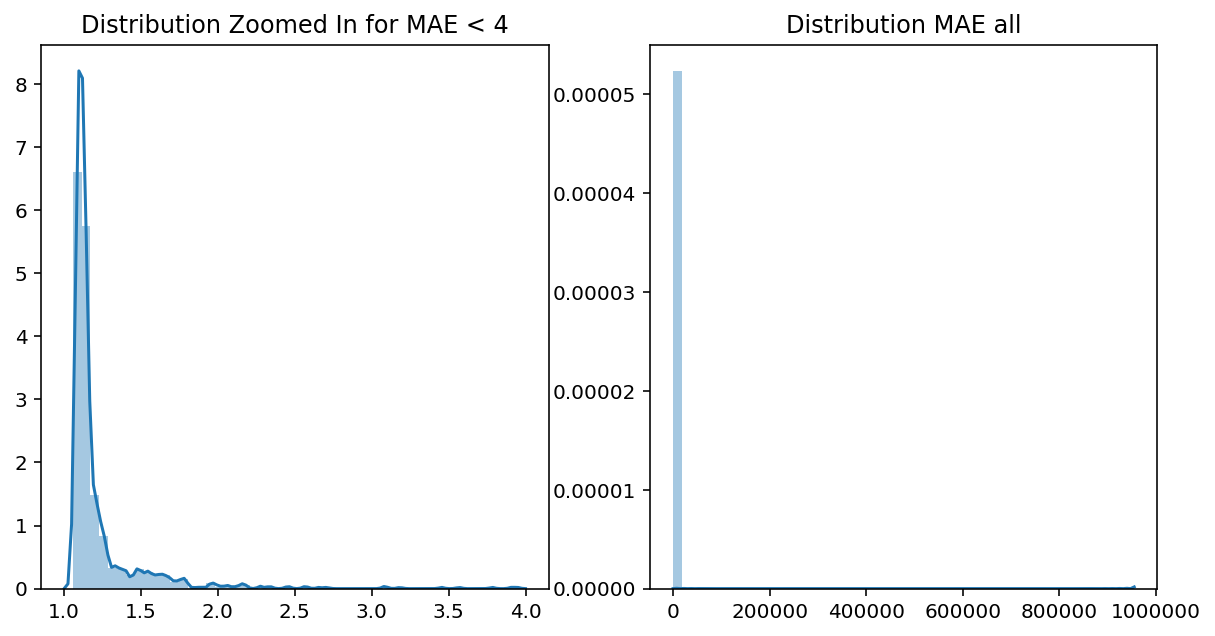

In [20]:
maes = np.array([results[result][2] for result in results])
plt.figure(figsize=(10,5))

plt.subplot(1,2,2)
sns.distplot(maes)
plt.title('Distribution MAE all')

plt.subplot(1,2,1)
sns.distplot(maes[maes < 4])
plt.title('Distribution Zoomed In for MAE < 4')
plt.show()

#### Which Features were really important?

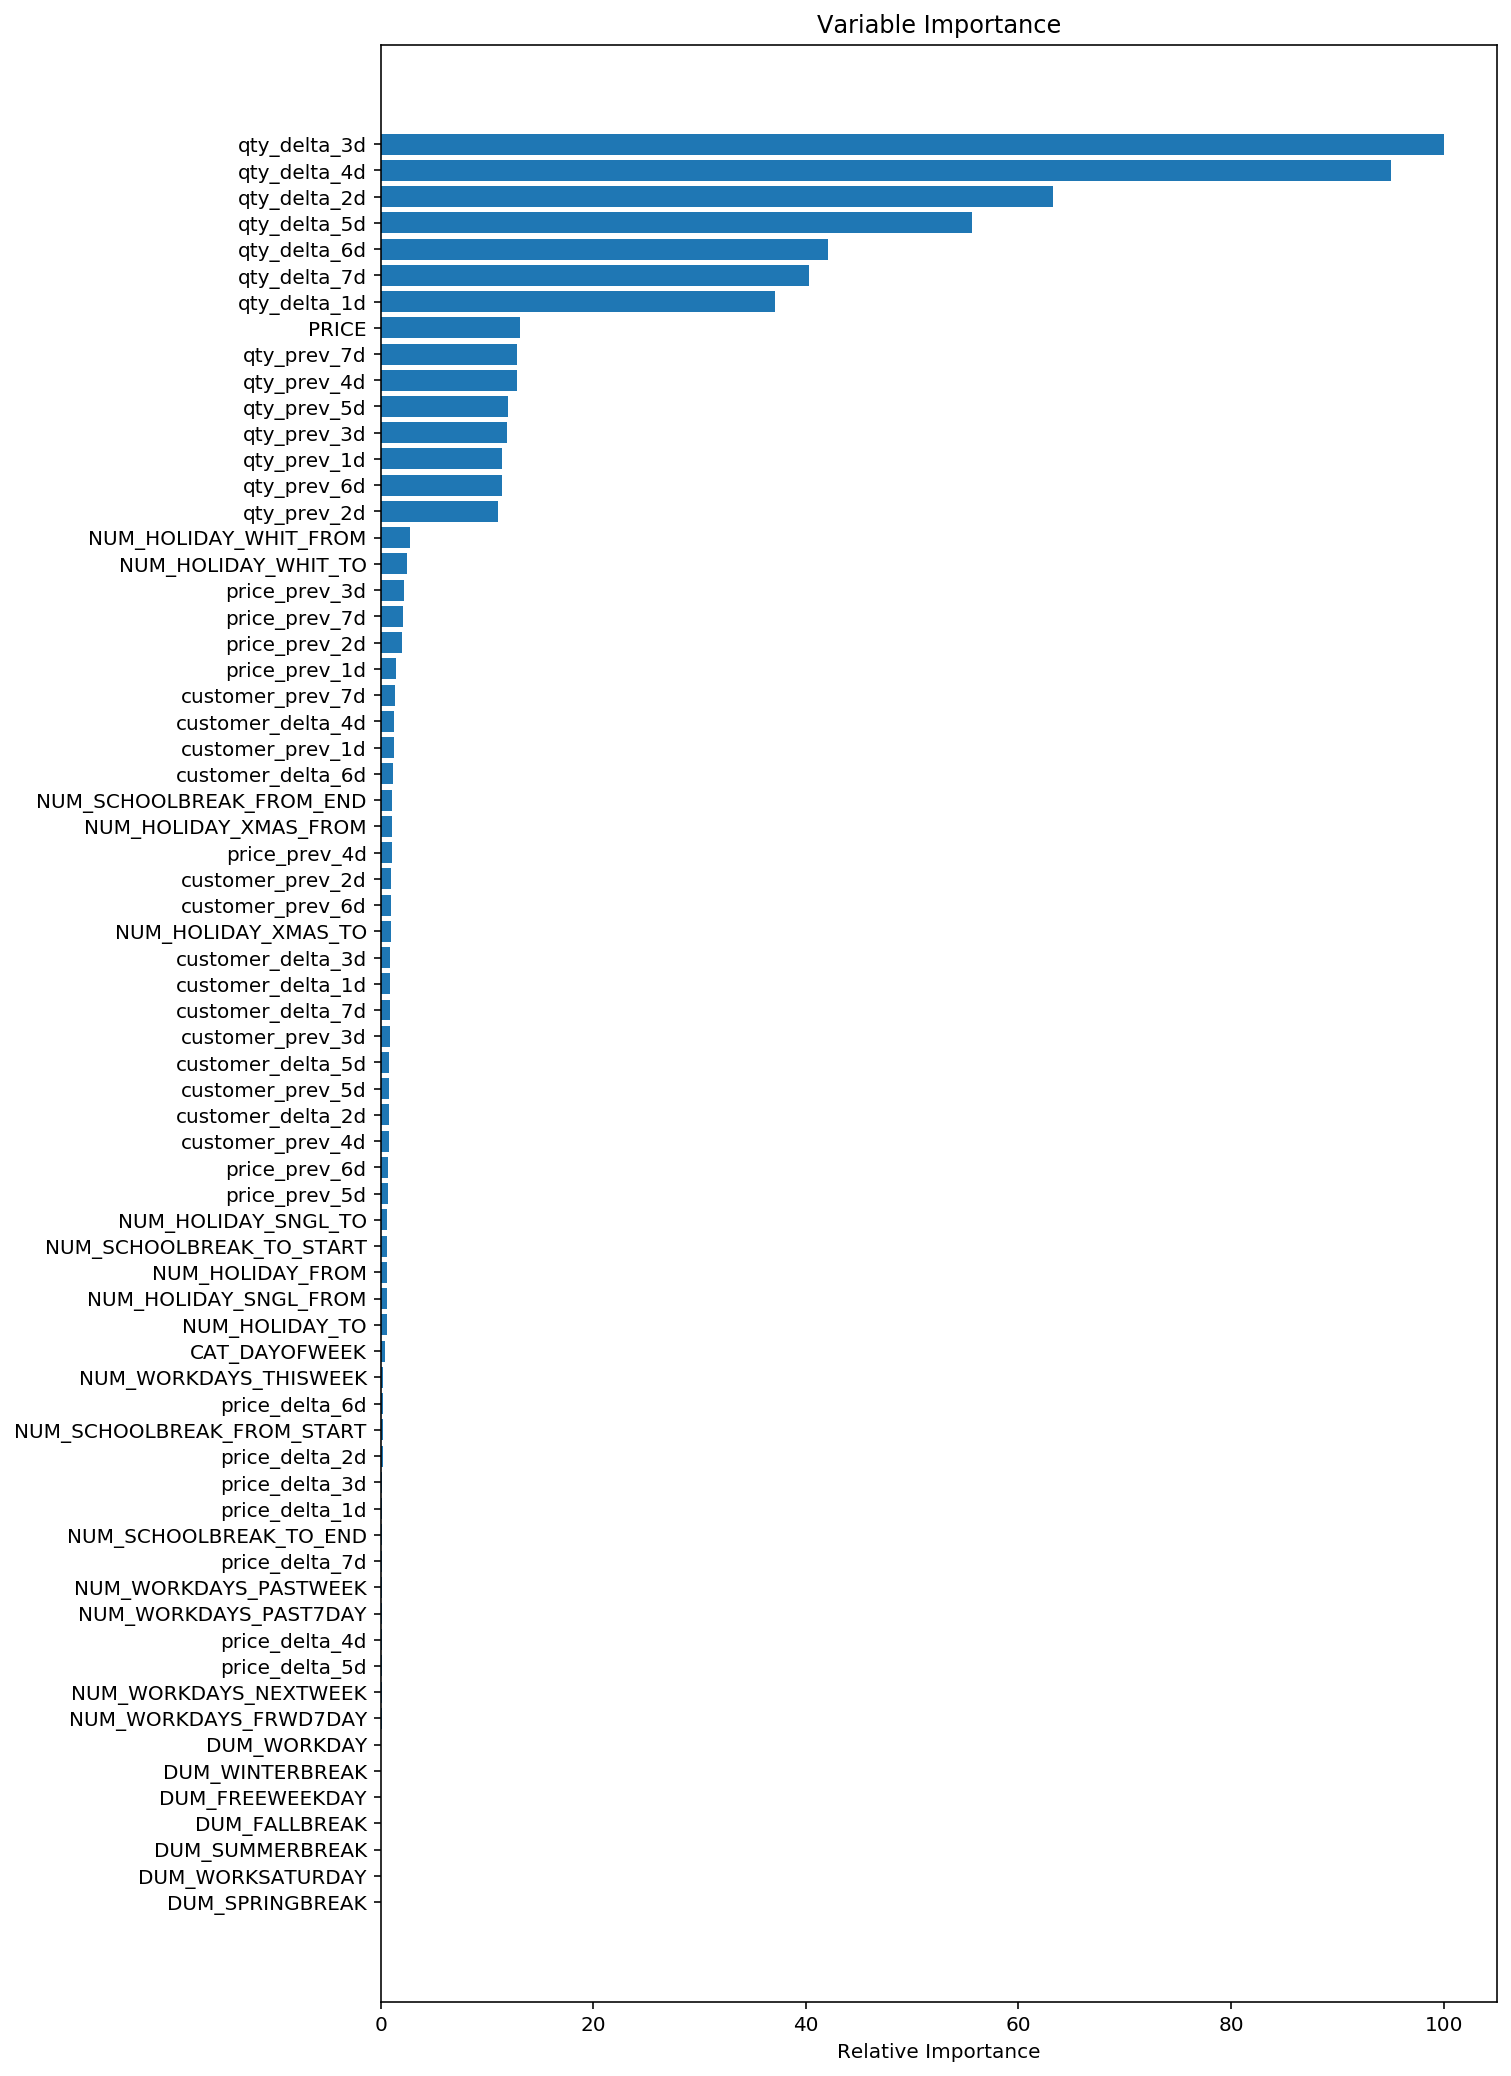

In [21]:
df_importances = pd.DataFrame(np.stack([results[result][1].feature_importances_ for result in results]),columns=features)
feature_importance = np.array([df_importances['{}'.format(key)].mean() for key in list(df_importances.keys())])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
plt.figure(figsize=(10,18))
plt.barh(pos, feature_importance[sorted_idx],align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Forecast: How many items will be sold in the next 7 days for each store and item?

In [22]:
random_store_id = int(random.choice(list(df.STORE_ID.unique())))
random_item_id = int(random.choice(list(df.ITEM_ID.unique())))
print('Lets check Store {} in combination with Item {}'.format(random_store_id,random_item_id))

Lets check Store 13 in combination with Item 22


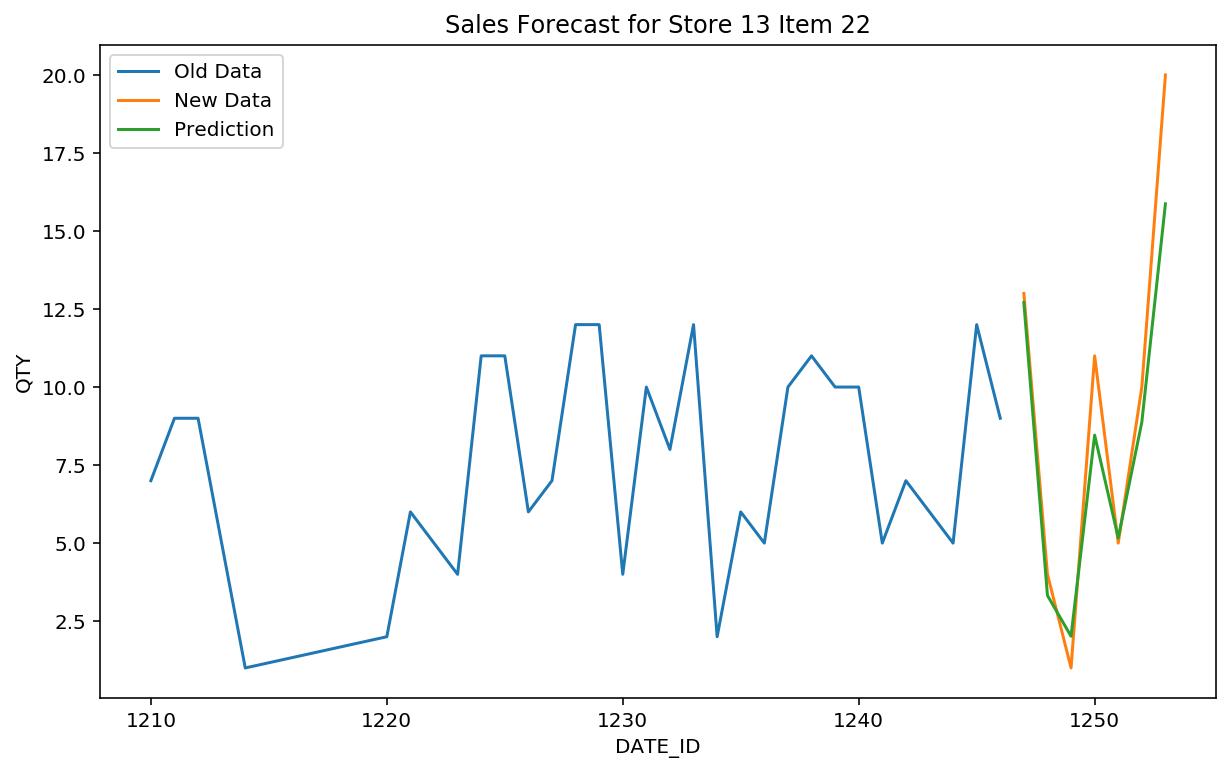

In [23]:
lookback_days = 30
plt.figure(figsize=(10,6))
startfrom = 500
store_item_combo='df_store_{}_item_{}'.format(random_store_id,random_item_id)
olddata = trainings[store_item_combo+'_old_data']
newdata = validations[store_item_combo+'_new_data']
sns.lineplot(olddata[olddata.DATE_ID>startfrom].DATE_ID[-lookback_days:],olddata.QTY[-lookback_days:], label = "Old Data")
sns.lineplot(newdata.DATE_ID,newdata.QTY, label = "New Data")
sns.lineplot(newdata.DATE_ID,np.exp(results[store_item_combo][1].predict(newdata[features])), label = "Prediction")
plt.title('Sales Forecast for Store {} Item {}'.format(random_store_id,random_item_id))
plt.show()

## 6. Conclusion

In average we are one product off with our predictions. What is not bad, considering that we're going with default settings so far. 

However, we have to think again about the prediction. Here it seems nice. But actually we'd only have data until today. So we can't know for example the difference of items sold in the next 4 days. So our predictions could only predict for the next day. Predicting the next 7 days would mean that we use the predictions from tomorrow as an input for the predictions for the day after tomorrow etc. Here in our example we used the luxury of data as a given. 

One way to cope with that would be to repeat the loop after each prediction using it to build additional features or to create the values missing with each new prediction.

We could also improve our predictions with implemented tuning in the loop, what we skipped here due to computational time requirements.

## Thank you!